In [1]:
# Descomentar esta linea para instalar paquetes necesarios solo la primera vez que se corra el codigo
! pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 4.2 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from arch import arch_model
from scipy.interpolate import CubicSpline
import yfinance as yf
from scipy.stats import norm
import seaborn as sns
from scipy import stats
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.ensemble import RandomForestRegressor
import os
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
n_paths = 100

In [3]:
!git clone https://github.com/pfernand47/Tasa-Cambio.git

Cloning into 'Tasa-Cambio'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 3.48 MiB | 9.39 MiB/s, done.
Resolving deltas: 100% (1/1), done.


## 0. Análisis Descriptivo

In [4]:
# Descargar datos históricos del tipo de cambio COP/USD
ticker = 'COP=X'
start_date = '2022-01-01'
end_date = '2024-09-29'
data = yf.download(ticker, start=start_date, end=end_date)

# Seleccionar solo la columna 'Close' y eliminar valores nulos
data = data[['Close']].dropna()

# Tipo de cambio spot actual
spot_rate = data['Close'][-1]

# Definir las tasas de interés a corto plazo
interest_rate_usd = 0.05  # 5% anual
interest_rate_cop = 0.1125  # 11.25% anual

# Volatilidad anualizada (utilizando desviación estándar de los retornos logarítmicos)
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1)).dropna()
volatility = np.std(data['Log_Return']) * np.sqrt(252)

# Plazos en días
days = [15, 20, 30]

[*********************100%***********************]  1 of 1 completed
<ipython-input-4-a2bbf9bd4ae8>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spot_rate = data['Close'][-1]


count     715.000000
mean     4202.152310
std       340.699739
min      3702.750000
25%      3936.349976
50%      4084.899902
75%      4461.866455
max      5106.000000
Name: Close, dtype: float64


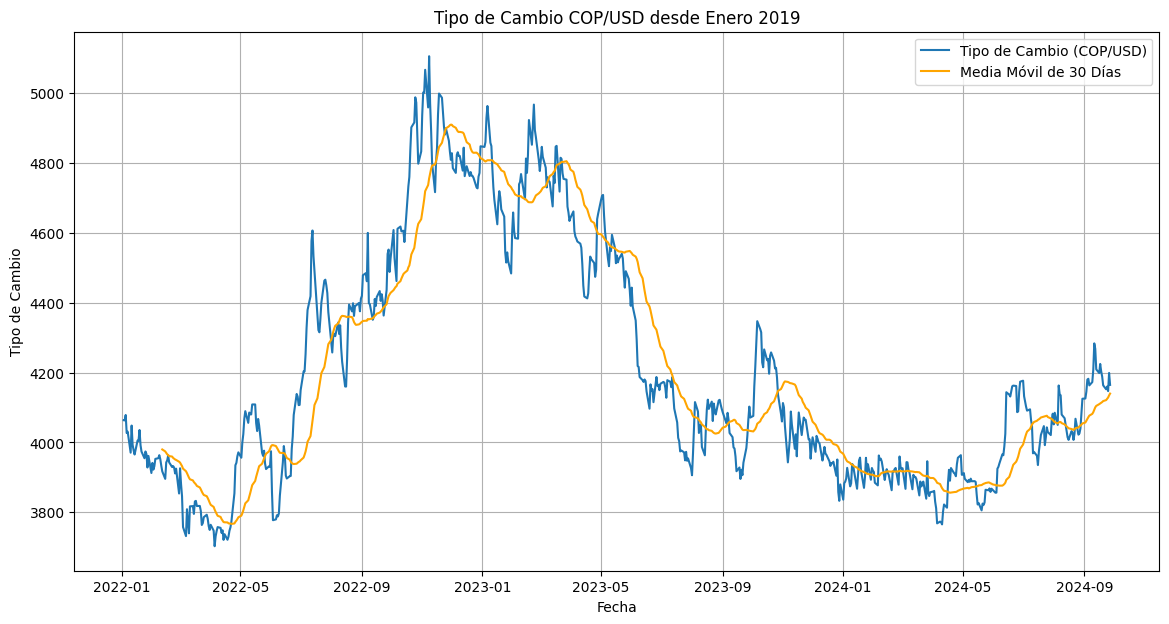

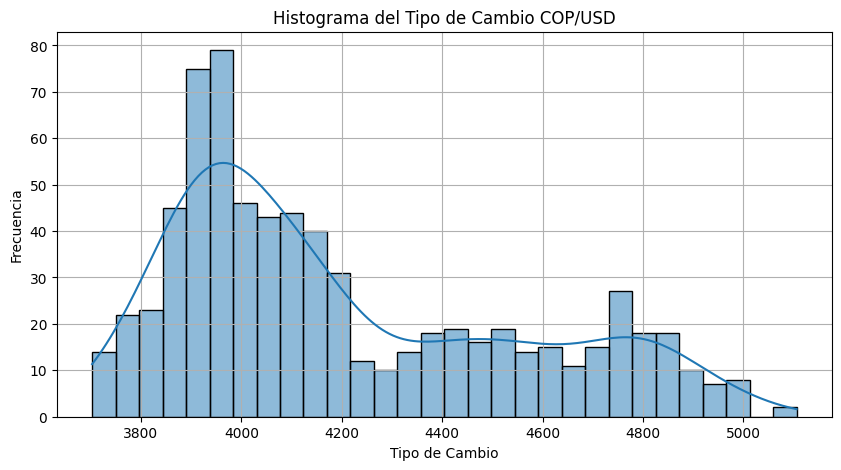

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


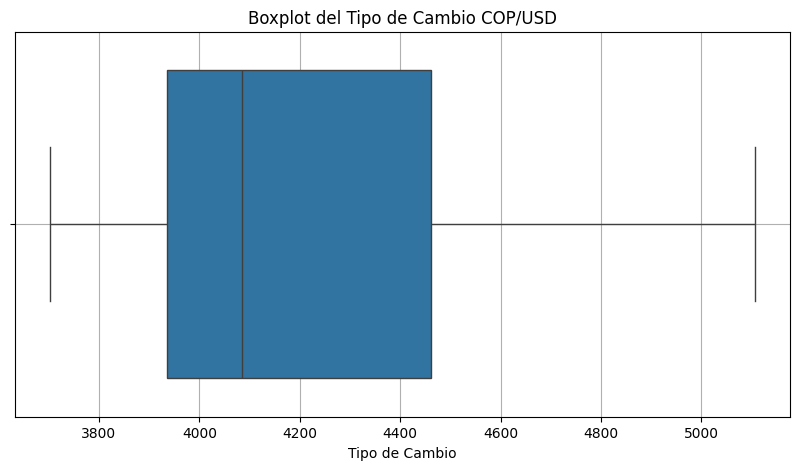

In [5]:
# Realizar análisis estadístico descriptivo
descriptive_stats = data['Close'].describe()
print(descriptive_stats)

# Calcular la media móvil (window=30 días)
data['30D_Moving_Avg'] = data['Close'].rolling(window=30).mean()

# Graficar la serie de tiempo y la media móvil
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Tipo de Cambio (COP/USD)')
plt.plot(data.index, data['30D_Moving_Avg'], label='Media Móvil de 30 Días', color='orange')
plt.title('Tipo de Cambio COP/USD desde Enero 2019')
plt.xlabel('Fecha')
plt.ylabel('Tipo de Cambio')
plt.legend()
plt.grid(True)
plt.show()

# Graficar histograma del tipo de cambio
plt.figure(figsize=(10, 5))
sns.histplot(data['Close'], bins=30, kde=True)
plt.title('Histograma del Tipo de Cambio COP/USD')
plt.xlabel('Tipo de Cambio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Graficar caja y bigotes (boxplot)
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['Close'])
plt.title('Boxplot del Tipo de Cambio COP/USD')
plt.xlabel('Tipo de Cambio')
plt.grid(True)
plt.show()


In [6]:
# Leer datos de Bloomberg
prices = pd.read_excel('Tasa-Cambio/tasa_cambio.xlsx', sheet_name= 'USDCOP', skiprows = [i for i in range(6)], index_col = 0)
prices = prices.sort_index()
prices = prices.iloc[:-1,:]
an_est = pd.read_excel('Tasa-Cambio/tasa_cambio.xlsx', sheet_name= 'Analyst_Estimates', index_col = 1)
an_est = an_est.iloc[:,[1,3]]
an_est = an_est.dropna()
an_est.columns = ['rango_inf', 'rango_sup']
an_est.index = an_est.index.astype('datetime64[ns]')
iv = pd.read_excel('Tasa-Cambio/tasa_cambio.xlsx', sheet_name= 'IV', usecols = [0,1,2], skiprows = [0,1], index_col = 0)
prices['Ret'] = prices['PX_LAST'].pct_change()
prices['Ret_log'] = np.log(prices['PX_LAST'] / prices['PX_LAST'].shift(1))
prices = prices.dropna()

In [7]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = prices.index,
        y = prices.PX_LAST,
        name = 'Serie Original',
        marker = dict(color='black')
    )
)

fig.add_trace(
    go.Scatter(
        x = prices.index,
        y = prices.PX_LAST.rolling(window=30).mean(),
        name = 'Media Móvil 1 Mes',
        marker = dict(color='Blue')
    )
)

fig.update_layout(
    title = 'Tasa de Cambio USDCOP',
    template = 'plotly_white',
    width = 1000, height = 500,
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.3,
    xanchor="right",
    x=0.7
))
fig.update_xaxes(title_text="Fecha")

### Calculo de retornos

Estadísticas Descriptivas de la Variación Porcentual:
count    714.000000
mean       0.000087
std        0.010223
min       -0.043794
25%       -0.005983
50%       -0.000586
75%        0.006119
max        0.035843
Name: Pct_Change, dtype: float64

Estadísticas Descriptivas de los Retornos Logarítmicos:
count    714.000000
mean       0.000034
std        0.010210
min       -0.044781
25%       -0.006001
50%       -0.000586
75%        0.006100
max        0.035215
Name: Log_Return, dtype: float64


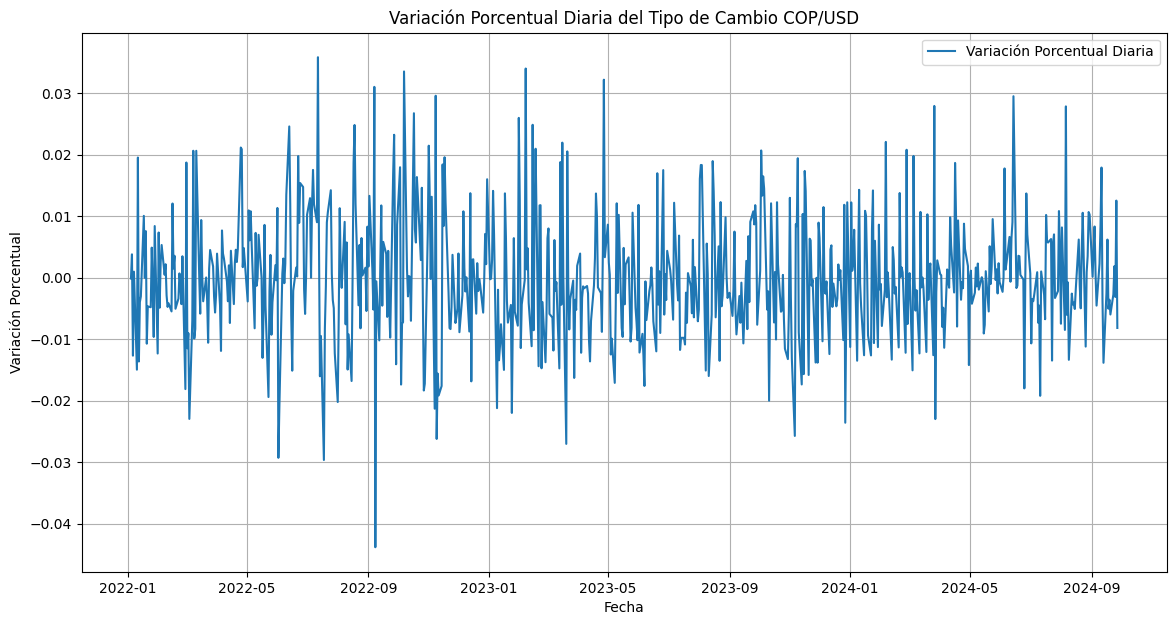

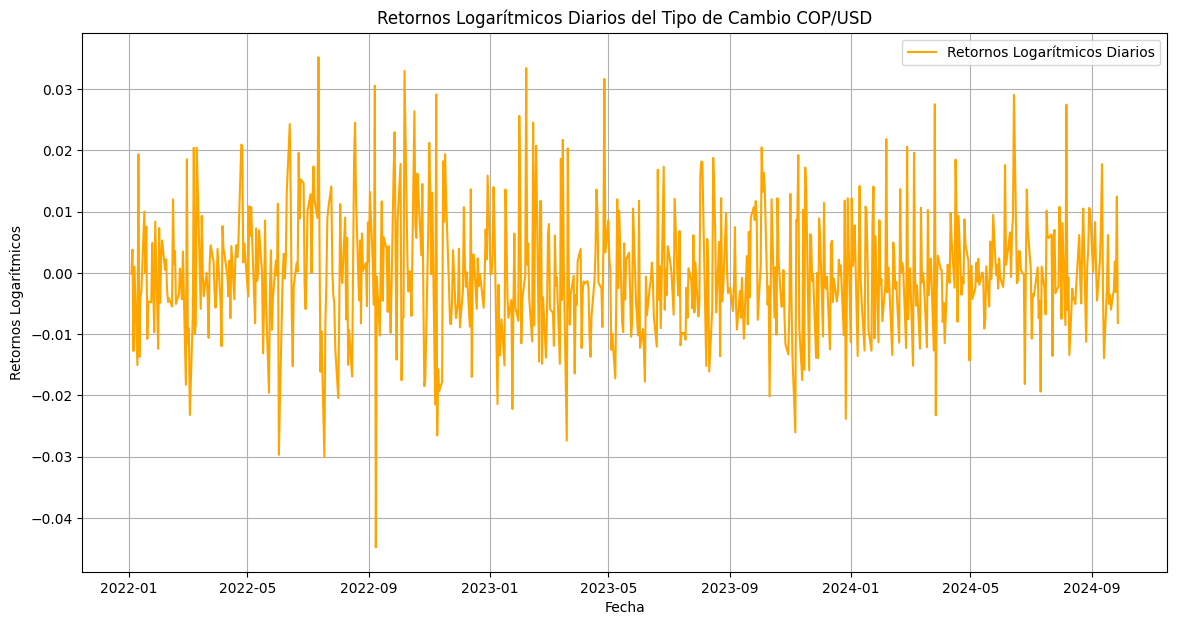

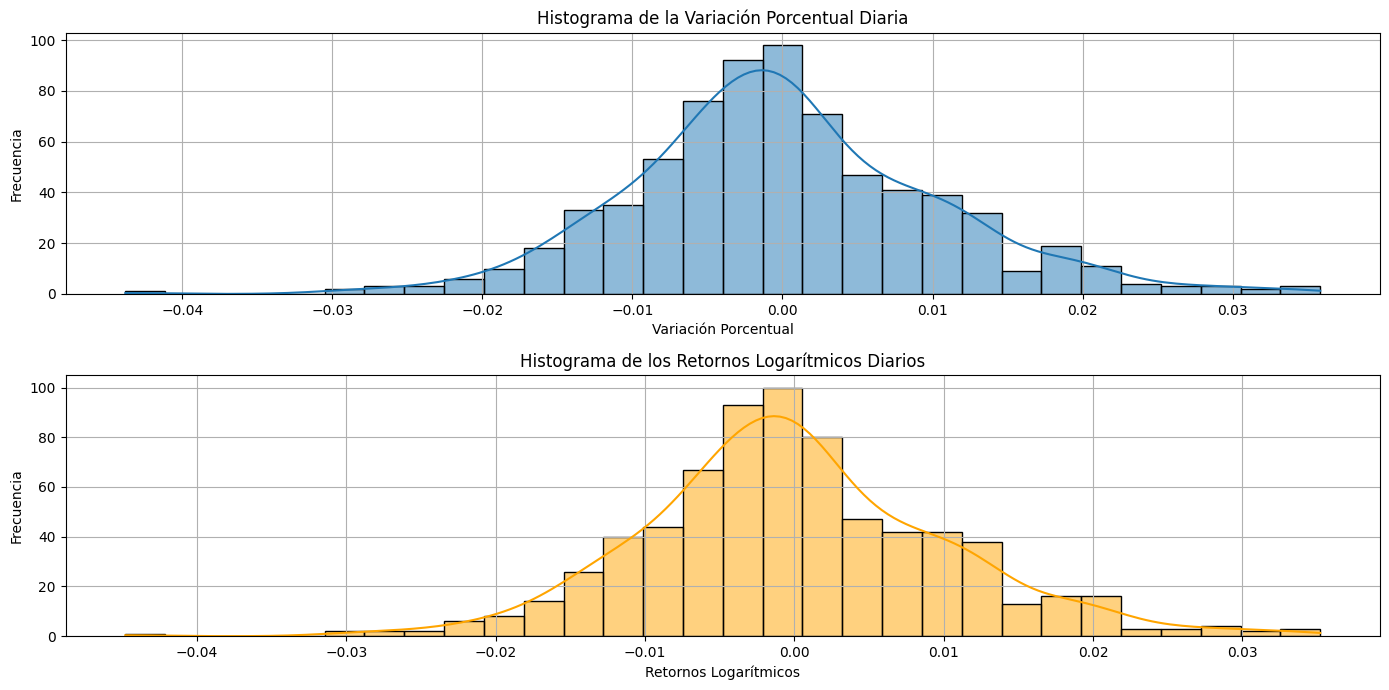

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



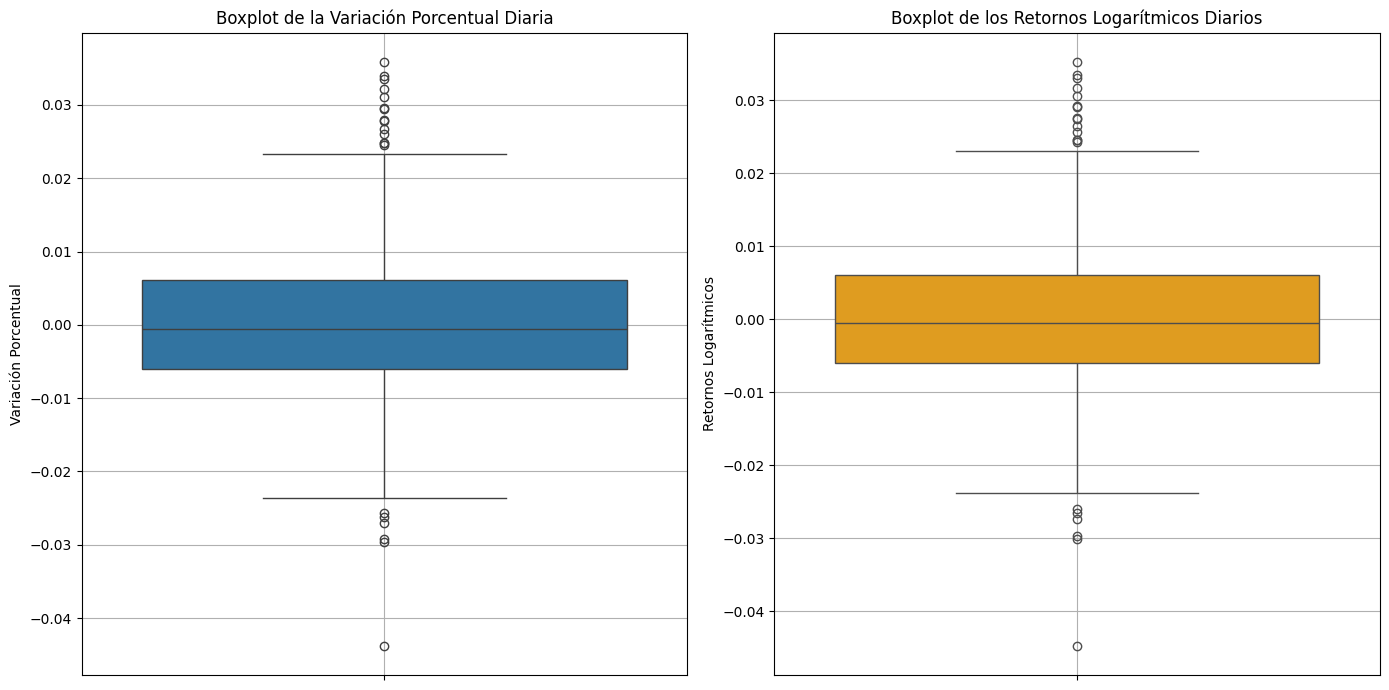

In [8]:
# Calcular la variación porcentual diaria
data['Pct_Change'] = data['Close'].pct_change().dropna()

# Calcular los retornos logarítmicos diarios
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1)).dropna()

# Descripción estadística de la variación porcentual y los retornos logarítmicos
pct_change_stats = data['Pct_Change'].describe()
log_return_stats = data['Log_Return'].describe()

print("Estadísticas Descriptivas de la Variación Porcentual:")
print(pct_change_stats)
print("\nEstadísticas Descriptivas de los Retornos Logarítmicos:")
print(log_return_stats)

# Graficar la variación porcentual diaria
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Pct_Change'], label='Variación Porcentual Diaria')
plt.title('Variación Porcentual Diaria del Tipo de Cambio COP/USD')
plt.xlabel('Fecha')
plt.ylabel('Variación Porcentual')
plt.legend()
plt.grid(True)
plt.show()

# Graficar los retornos logarítmicos diarios
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Log_Return'], label='Retornos Logarítmicos Diarios', color='orange')
plt.title('Retornos Logarítmicos Diarios del Tipo de Cambio COP/USD')
plt.xlabel('Fecha')
plt.ylabel('Retornos Logarítmicos')
plt.legend()
plt.grid(True)
plt.show()

# Graficar histogramas de la variación porcentual y los retornos logarítmicos
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
sns.histplot(data['Pct_Change'], bins=30, kde=True)
plt.title('Histograma de la Variación Porcentual Diaria')
plt.xlabel('Variación Porcentual')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.subplot(2, 1, 2)
sns.histplot(data['Log_Return'], bins=30, kde=True, color='orange')
plt.title('Histograma de los Retornos Logarítmicos Diarios')
plt.xlabel('Retornos Logarítmicos')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.tight_layout()
plt.show()

# Graficar boxplots de la variación porcentual y los retornos logarítmicos
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.boxplot(y=data['Pct_Change'])
plt.title('Boxplot de la Variación Porcentual Diaria')
plt.ylabel('Variación Porcentual')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(y=data['Log_Return'], color='orange')
plt.title('Boxplot de los Retornos Logarítmicos Diarios')
plt.ylabel('Retornos Logarítmicos')
plt.grid(True)

plt.tight_layout()
plt.show()


### Pruebas de Normalidad

In [9]:
#Eliminar las primeras filas con valores nulos generados por el cálculo de pct_change y log_return
data = data.dropna()

# Pruebas de normalidad
# Shapiro-Wilk test
shapiro_pct_change = stats.shapiro(data['Pct_Change'])
shapiro_log_return = stats.shapiro(data['Log_Return'])

print("Prueba Shapiro-Wilk para Variación Porcentual Diaria:")
print(f"Estadístico: {shapiro_pct_change[0]}, p-valor: {shapiro_pct_change[1]}")

print("\nPrueba Shapiro-Wilk para Retornos Logarítmicos Diarios:")
print(f"Estadístico: {shapiro_log_return[0]}, p-valor: {shapiro_log_return[1]}")

# Prueba de Kolmogorov-Smirnov
ks_pct_change = stats.kstest(data['Pct_Change'], 'norm', args=(data['Pct_Change'].mean(), data['Pct_Change'].std()))
ks_log_return = stats.kstest(data['Log_Return'], 'norm', args=(data['Log_Return'].mean(), data['Log_Return'].std()))

print("\nPrueba Kolmogorov-Smirnov para Variación Porcentual Diaria:")
print(f"Estadístico: {ks_pct_change[0]}, p-valor: {ks_pct_change[1]}")

print("\nPrueba Kolmogorov-Smirnov para Retornos Logarítmicos Diarios:")
print(f"Estadístico: {ks_log_return[0]}, p-valor: {ks_log_return[1]}")

# Verificar ajuste a una distribución lognormal
# Transformar datos para prueba lognormal
data['Pct_Change_Log'] = np.log(data['Pct_Change'] + 1)
data['Log_Return_Log'] = np.log(data['Log_Return'] + 1)

# Pruebas de normalidad para datos transformados
shapiro_pct_change_log = stats.shapiro(data['Pct_Change_Log'])
shapiro_log_return_log = stats.shapiro(data['Log_Return_Log'])

print("\nPrueba Shapiro-Wilk para Transformación Logarítmica de la Variación Porcentual Diaria:")
print(f"Estadístico: {shapiro_pct_change_log[0]}, p-valor: {shapiro_pct_change_log[1]}")

print("\nPrueba Shapiro-Wilk para Transformación Logarítmica de los Retornos Logarítmicos Diarios:")
print(f"Estadístico: {shapiro_log_return_log[0]}, p-valor: {shapiro_log_return_log[1]}")

Prueba Shapiro-Wilk para Variación Porcentual Diaria:
Estadístico: 0.9864480352407142, p-valor: 5.541710977704124e-06

Prueba Shapiro-Wilk para Retornos Logarítmicos Diarios:
Estadístico: 0.9872780474194761, p-valor: 1.1135283273621363e-05

Prueba Kolmogorov-Smirnov para Variación Porcentual Diaria:
Estadístico: 0.07033860093521471, p-valor: 0.002139711038727541

Prueba Kolmogorov-Smirnov para Retornos Logarítmicos Diarios:
Estadístico: 0.06834162981354874, p-valor: 0.0031351021109211376

Prueba Shapiro-Wilk para Transformación Logarítmica de la Variación Porcentual Diaria:
Estadístico: 0.9872780474194761, p-valor: 1.1135283273621363e-05

Prueba Shapiro-Wilk para Transformación Logarítmica de los Retornos Logarítmicos Diarios:
Estadístico: 0.9879282457824867, p-valor: 1.953239353180286e-05


<ipython-input-9-fae79be9e453>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-fae79be9e453>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



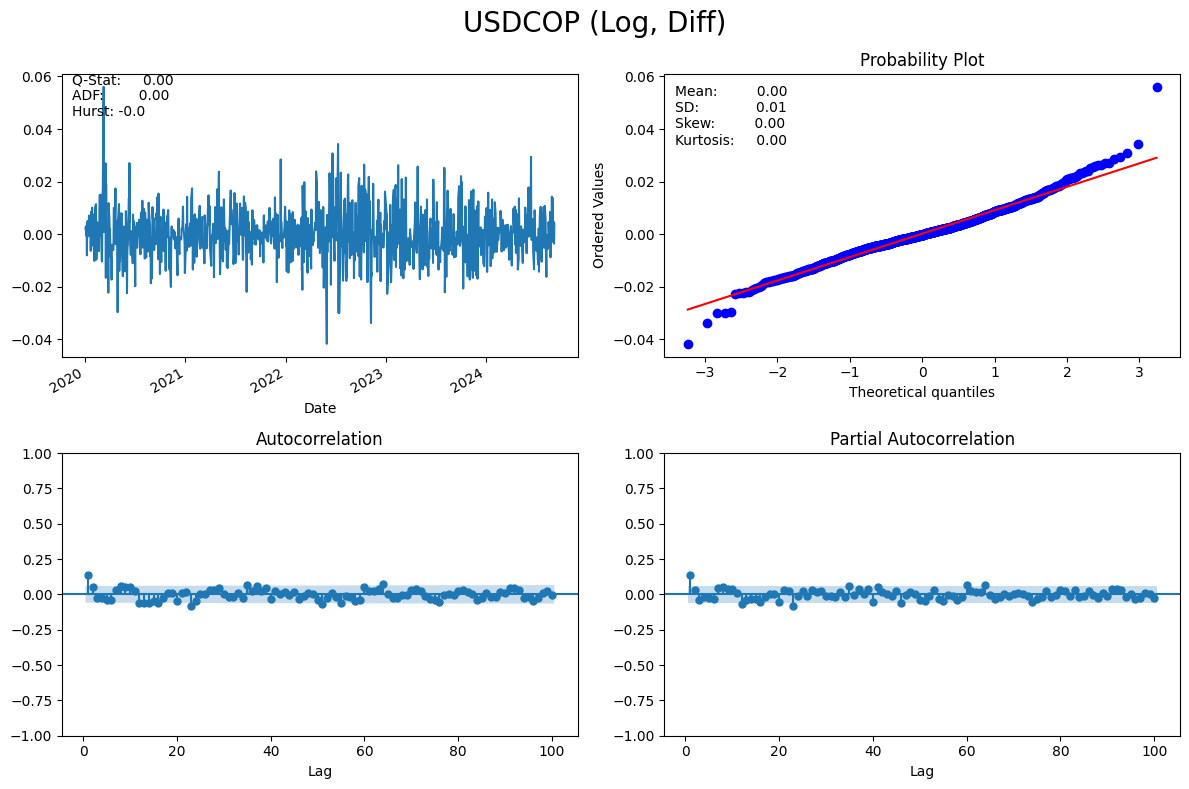

In [10]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def plot_correlogram(x, lags=None, title=None):
  lags = min(10, int(len(x)/5)) if lags is None else lags
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
  x.plot(ax=axes[0][0])
  q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
  stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
  axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
  probplot(x, plot=axes[0][1])
  mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
  s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
  axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
  plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
  plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
  axes[1][0].set_xlabel('Lag')
  axes[1][1].set_xlabel('Lag')
  fig.suptitle(title, fontsize=20)
  fig.tight_layout()
  fig.subplots_adjust(top=.9)

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(prices['Ret_log'], lags=100, title='USDCOP (Log, Diff)')

## 1. Volatilidad

In [11]:
vol_an = (prices['Ret_log'].rolling(window=252).std() * np.sqrt(252)).dropna()
vol_ewa = prices['Ret_log'].ewm(span=30).std()* np.sqrt(252)
# GARCH (1,1)
garch_model = arch_model(prices['Ret_log'], vol='GARCH', p=1, q=1)
garch_fit = garch_model.fit(disp="off")
vol_garch = garch_fit.conditional_volatility * np.sqrt(252)
forecast = garch_fit.forecast(start=prices.index[-1], horizon=252)
forecast_vol = np.sqrt(forecast.variance.values.flatten())* np.sqrt(252)
last_day = prices.index[-1]
forecast_index = [last_day + datetime.timedelta(days=i) for i in range(len(forecast_vol))]
# EGARCH model
egarch_gm = arch_model(prices['Ret_log'], vol='EGARCH', p=1, q=1, o=1)
egarch_result = egarch_gm.fit(disp = 'off')
egarch_vol = egarch_result.conditional_volatility * np.sqrt(252)

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.094e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.094e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [12]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = vol_an.index,
        y = vol_an.values,
        name = 'Volatilidad Histórica',
        marker = dict(color='green')
    )
)

fig.add_trace(
    go.Scatter(
        x = vol_ewa.index,
        y = vol_ewa.values,
        name = 'Volatilidad EWMA',
        marker = dict(color='blue')
    )
)

fig.add_trace(
    go.Scatter(
        x = vol_garch.index,
        y = vol_garch.values,
        name = 'Volatilidad Condicional GARCH(1,1)',
        marker = dict(color='orange')
    )
)

fig.add_trace(
    go.Scatter(
        x = egarch_vol.index,
        y = egarch_vol.values,
        name = 'Volatilidad Condicional EGARCH(1,1)',
        marker = dict(color='purple')
    )
)

fig.add_trace(
    go.Scatter(
        x = forecast_index,
        y = forecast_vol,
        name = 'Pronostico Volatilidad Condicional GARCH(1,1)',
        line = dict(color='orange', dash = 'dash')
    )
)

fig.update_layout(
    title = 'Volatilidad Tasa de Cambio USDCOP',
    template = 'plotly_white',
    width = 1000, height = 500,
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.3,
    xanchor="right",
    x=0.9
)
)
fig.update_xaxes(title_text="Fecha")

In [13]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = iv.index,
        y = iv.Bid/100,
        name = 'Bid',
        marker = dict(color='green')
    )
)

fig.add_trace(
    go.Scatter(
        x = iv.index,
        y = iv.Ask/100,
        name = 'Ask',
        marker = dict(color='green')
    )
)

fig.update_layout(
    title = 'Volatilidad Implicita Tasa de Cambio USDCOP',
    template = 'plotly_white',
    width = 1000, height = 500,
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.3,
    xanchor="right",
    x=0.56
)
)
fig.update_xaxes(title_text="Tiempo")

## 2. Proyección Tasa de Cambio

In [14]:
def lognormal_price_paths(s0,mu, sigma, dt,n_paths, T = 252):
    col_names = ['Path {}'.format(i+1) for i in range(n_paths)]
    paths = pd.DataFrame(columns = col_names)
    paths.loc[0,:] = s0
    for i in range(T):
        for j in range(n_paths):
            paths.loc[i+1,'Path {}'.format(j+1)] =paths.iloc[i,j]*np.exp((mu -0.5*(sigma**2))*dt + sigma*np.sqrt(dt)*np.random.normal())
    return paths

def lognormal_price_garch(s0,mu, forecast_vol, dt,n_paths, T = 252):
    col_names = ['Path {}'.format(i+1) for i in range(n_paths)]
    paths = pd.DataFrame(columns = col_names)
    paths.loc[0,:] = s0
    for i in range(T):
        for j in range(n_paths):
            sigma = float(forecast_vol[i])
            paths.loc[i+1,'Path {}'.format(j+1)] =paths.iloc[i,j]*np.exp((mu -0.5*(sigma**2))*dt + sigma*np.sqrt(dt)*np.random.normal())
    return paths

In [15]:
vol_hist = prices['Ret_log'].std()*np.sqrt(252)
mu = (1+prices['Ret_log'].mean())**252-1
sims = lognormal_price_paths(s0 = prices['PX_LAST'][-1],mu = mu, sigma = vol_hist, dt = 1/252, n_paths = n_paths, T = 252)
last_day = prices.index[-1]
new_index = [last_day + datetime.timedelta(days=i) for i in sims.index]
sims.index = new_index

<ipython-input-15-8b66e80c2ef2>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [16]:
def plot_random_walks(sims, prices, an_est, title):
  fig = go.Figure()
  for sim in sims.columns:
      fig.add_trace(
          go.Scatter(
              x = sims.index,
              y = sims[sim],
              name = sim,
              marker = dict(color='gray'),
              showlegend = False
          )
      )
  fig.add_trace(
      go.Scatter(
          x = prices.index,
          y = prices.PX_LAST,
          name = 'Serie Original',
          marker = dict(color='black')
      )
  )

  fig.add_trace(
      go.Scatter(
          x = sims.index,
          y = sims.mean(axis=1),
          name = 'Media Caminatas Aleatorias',
          line = dict(color='black', dash = 'dash')
      )
  )

  fig.add_trace(
      go.Scatter(
          x = an_est[an_est.index<= sims.index[-1]].index,
          y = an_est[an_est.index<= sims.index[-1]].rango_inf,
          name = 'Analyst Estimates Bloomberg',
          line = dict(color='blue', dash = 'dash')
      )
  )

  fig.add_trace(
      go.Scatter(
          x = an_est[an_est.index<= sims.index[-1]].index,
          y = an_est[an_est.index<= sims.index[-1]].rango_sup,
          showlegend = False,
          name = 'Analyst Estimates Bloomberg',
          line = dict(color='blue', dash = 'dash')
      )
  )

  fig.update_layout(
      title = title,
      template = 'plotly_white',
      width = 1000, height = 500,
      legend=dict(
      orientation="h",
      entrywidth=180,
      yanchor="bottom",
      y=-0.3,
      xanchor="right",
      x=0.8
  ))
  fig.update_xaxes(title_text="Fecha")
  return fig

In [17]:
plot_random_walks(sims, prices, an_est, 'Simulación Caminatas Aleatorias USDCOP con MBG')

In [18]:
sims_garch = lognormal_price_garch(s0 = prices['PX_LAST'][-1],mu = mu, forecast_vol = forecast_vol, dt = 1/252, n_paths = n_paths, T = 252)
last_day = prices.index[-1]
new_index = [last_day + datetime.timedelta(days=i) for i in sims_garch.index]
sims_garch.index = new_index

<ipython-input-18-2f6fedf151ee>:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [19]:
plot_random_walks(sims_garch, prices, an_est,'Simulación Caminatas Aleatorias USDCOP con MBG + GARCH'  )

In [20]:
# Descargar datos históricos del tipo de cambio COP/USD
ticker = 'COP=X'
start_date = '2019-01-01'
end_date = '2024-07-01'
data = yf.download(ticker, start=start_date, end=end_date)

# Seleccionar solo la columna 'Close' y eliminar valores nulos
data = data[['Close']].dropna()

# Calcular los retornos logarítmicos diarios
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1)).dropna()

# Eliminar las primeras filas con valores nulos generados por el cálculo de log_return
data = data.dropna()

# Definir horizontes de proyección
horizons = [5, 10, 15, 20, 30]


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.902e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This war

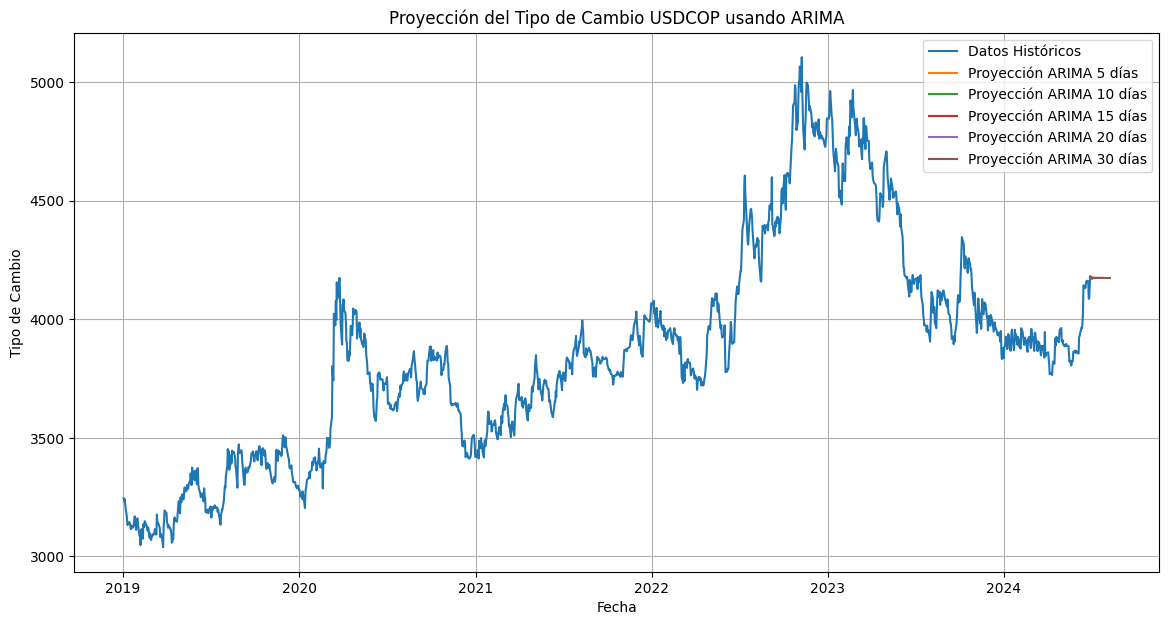

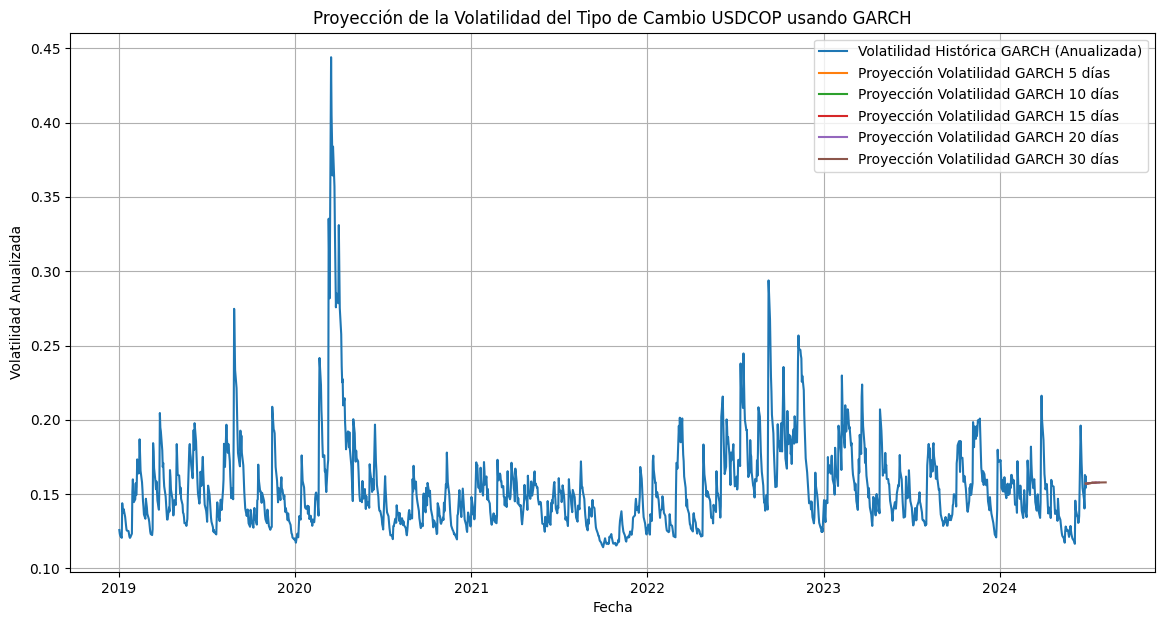

In [21]:
# Ajustar el modelo ARIMA
arima_model = ARIMA(data['Close'], order=(5, 1, 0))
arima_fit = arima_model.fit()

# Ajustar el modelo GARCH
garch_model = arch_model(data['Log_Return'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")

# Proyecciones ARIMA
arima_forecasts = {}
for horizon in horizons:
    arima_forecasts[horizon] = arima_fit.forecast(steps=horizon)

# Proyecciones GARCH
garch_forecasts = {}
for horizon in horizons:
    garch_forecast = garch_fit.forecast(horizon=horizon)
    garch_forecasts[horizon] = np.sqrt(garch_forecast.variance.values[-1, :]) * np.sqrt(252)  # Anualizar la volatilidad

# Graficar las proyecciones del tipo de cambio
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Datos Históricos')
for horizon in horizons:
    plt.plot(pd.date_range(data.index[-1], periods=horizon, freq='B'), arima_forecasts[horizon], label=f'Proyección ARIMA {horizon} días')
plt.title('Proyección del Tipo de Cambio USDCOP usando ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Tipo de Cambio')
plt.legend()
plt.grid(True)
plt.show()

# Graficar las proyecciones de volatilidad
plt.figure(figsize=(14, 7))
plt.plot(data.index, garch_fit.conditional_volatility * np.sqrt(252), label='Volatilidad Histórica GARCH (Anualizada)')
for horizon in horizons:
    plt.plot(pd.date_range(data.index[-1], periods=horizon, freq='B'), garch_forecasts[horizon], label=f'Proyección Volatilidad GARCH {horizon} días')
plt.title('Proyección de la Volatilidad del Tipo de Cambio USDCOP usando GARCH')
plt.xlabel('Fecha')
plt.ylabel('Volatilidad Anualizada')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Escalar los datos
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Convertir a DataFrame escalado
train_scaled = pd.DataFrame(train_scaled, columns=train_data.columns, index=train_data.index)
test_scaled = pd.DataFrame(test_scaled, columns=test_data.columns, index=test_data.index)

# Función para crear una estructura de datos de series temporales
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back)]
        X.append(a)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

look_back = 30  # Usar los últimos 30 días para predecir el siguiente día

# Crear conjuntos de entrenamiento y prueba para el modelo
X_train, y_train = create_dataset(train_scaled['Close'], look_back)
X_test, y_test = create_dataset(test_scaled['Close'], look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


<ipython-input-22-40efd0df33c5>:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
1115/1115 - 21s - 19ms/step - loss: 0.0383
Epoch 2/20
1115/1115 - 22s - 19ms/step - loss: 0.0182
Epoch 3/20
1115/1115 - 19s - 17ms/step - loss: 0.0125
Epoch 4/20
1115/1115 - 15s - 13ms/step - loss: 0.0098
Epoch 5/20
1115/1115 - 14s - 13ms/step - loss: 0.0095
Epoch 6/20
1115/1115 - 21s - 19ms/step - loss: 0.0093
Epoch 7/20
1115/1115 - 15s - 14ms/step - loss: 0.0089
Epoch 8/20
1115/1115 - 14s - 13ms/step - loss: 0.0095
Epoch 9/20
1115/1115 - 21s - 18ms/step - loss: 0.0090
Epoch 10/20
1115/1115 - 14s - 13ms/step - loss: 0.0091
Epoch 11/20
1115/1115 - 20s - 18ms/step - loss: 0.0090
Epoch 12/20
1115/1115 - 14s - 13ms/step - loss: 0.0084
Epoch 13/20
1115/1115 - 15s - 13ms/step - loss: 0.0085
Epoch 14/20
1115/1115 - 14s - 13ms/step - loss: 0.0087
Epoch 15/20
1115/1115 - 14s - 13ms/step - loss: 0.0085
Epoch 16/20
1115/1115 - 14s - 13ms/step - loss: 0.0090
Epoch 17/20
1115/1115 - 20s - 18ms/step - loss: 0.0085
Epoch 18/20
1115/1115 - 14s - 13ms/step - loss: 0.0085
Epoch 19/20
1115/11

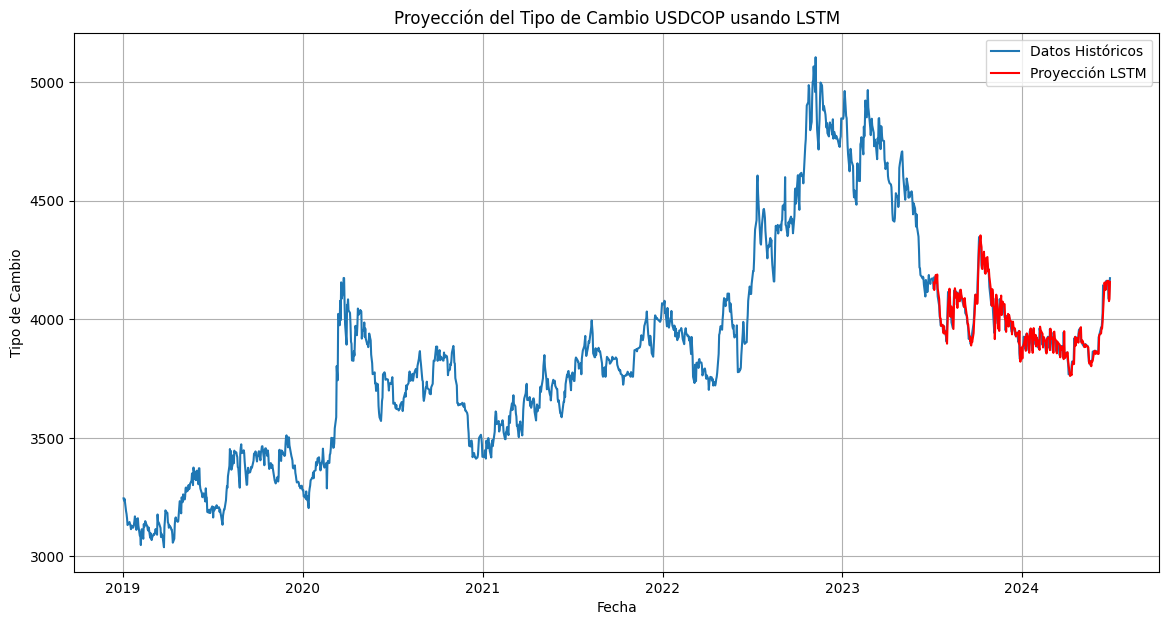

In [23]:
# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)

# Hacer proyecciones
lstm_predictions = model.predict(X_test)
# Reshape LSTM predictions to match the number of features the scaler was fitted on
lstm_predictions = lstm_predictions.reshape(-1, 1)  # Reshape to (257, 1)

# Reshape LSTM predictions to match the number of features the scaler was fitted on
lstm_predictions = lstm_predictions.reshape(-1, 1)

# Create a dummy array for the 'Log_Return' column to match the original data shape
dummy_log_returns = np.zeros_like(lstm_predictions)

# Concatenate the predictions and dummy log returns
lstm_predictions_with_dummy = np.concatenate((lstm_predictions, dummy_log_returns), axis=1)

# Now inverse transform the concatenated array
lstm_predictions_original_scale = scaler.inverse_transform(lstm_predictions_with_dummy)

# Extract the predictions for the 'Close' column (the first column)
lstm_predictions = lstm_predictions_original_scale[:, 0]

# Graficar las proyecciones
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Datos Históricos')
plt.plot(test_data.index[look_back:], lstm_predictions, label='Proyección LSTM', color='red')
plt.title('Proyección del Tipo de Cambio USDCOP usando LSTM')
plt.xlabel('Fecha')
plt.ylabel('Tipo de Cambio')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-22-40efd0df33c5>:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



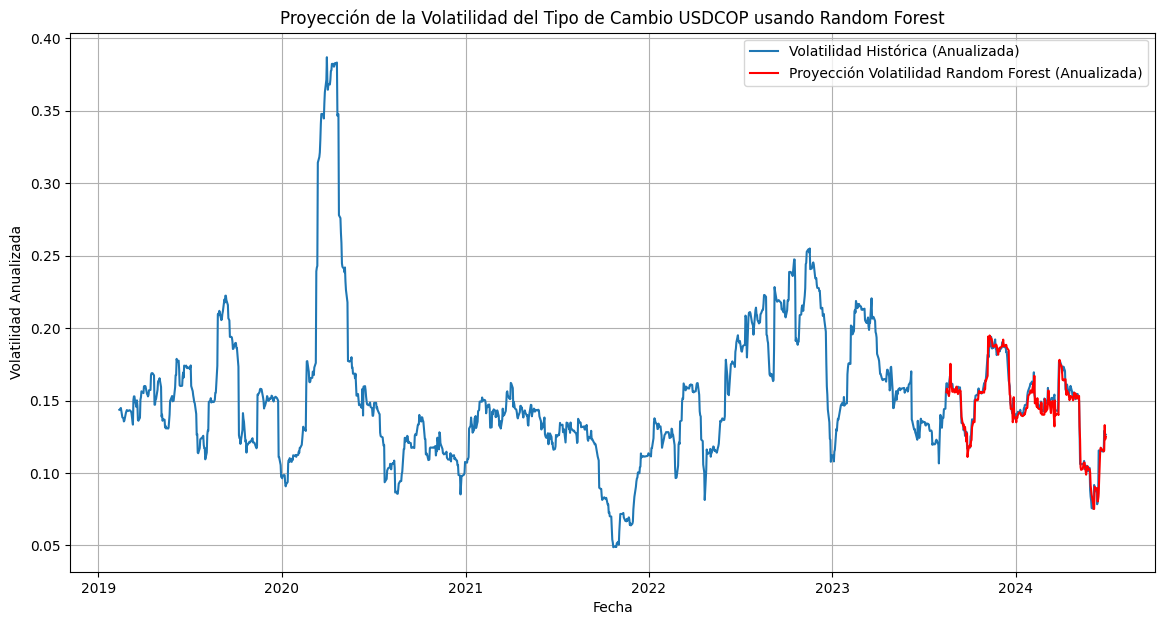

In [24]:
# Crear el conjunto de datos para la volatilidad
volatility_look_back = 30  # Usar los últimos 30 días para predecir la volatilidad
X_vol_train, y_vol_train = create_dataset(train_scaled['Log_Return'].rolling(volatility_look_back).std().dropna(), volatility_look_back)
X_vol_test, y_vol_test = create_dataset(test_scaled['Log_Return'].rolling(volatility_look_back).std().dropna(), volatility_look_back)

# Reshape input to be [samples, time steps, features]
X_vol_train = np.reshape(X_vol_train, (X_vol_train.shape[0], X_vol_train.shape[1]))
X_vol_test = np.reshape(X_vol_test, (X_vol_test.shape[0], X_vol_test.shape[1]))

# Crear y entrenar el modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_vol_train, y_vol_train)

# Hacer proyecciones
rf_predictions = rf_model.predict(X_vol_test)
rf_predictions = rf_predictions * np.sqrt(252)  # Anualizar la volatilidad

# Graficar las proyecciones de volatilidad
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Log_Return'].rolling(volatility_look_back).std() * np.sqrt(252), label='Volatilidad Histórica (Anualizada)')

# Correctly calculate the index for plotting to match the length of rf_predictions
plot_index = test_data.index[volatility_look_back:]
plt.plot(plot_index[-len(rf_predictions):], rf_predictions/100, label='Proyección Volatilidad Random Forest (Anualizada)', color='red')

plt.title('Proyección de la Volatilidad del Tipo de Cambio USDCOP usando Random Forest')
plt.xlabel('Fecha')
plt.ylabel('Volatilidad Anualizada')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Parámetros
i_USD = 0.05
i_COP = 0.1125
infl_USD = 0.035
infl_COP = 0.0718
S = data['Close'][-1]

# Proyección a un año basado en UIP
E_S_UIP = S * (1 + i_COP - i_USD)

# Proyección a un año basado en IFE
E_S_IFE = S * (1 + infl_COP - infl_USD)

print(f"Proyección UIP: {E_S_UIP:.2f} COP/USD")
print(f"Proyección IFE: {E_S_IFE:.2f} COP/USD")

Proyección UIP: 4434.75 COP/USD
Proyección IFE: 4327.48 COP/USD


<ipython-input-25-a02be603be3b>:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



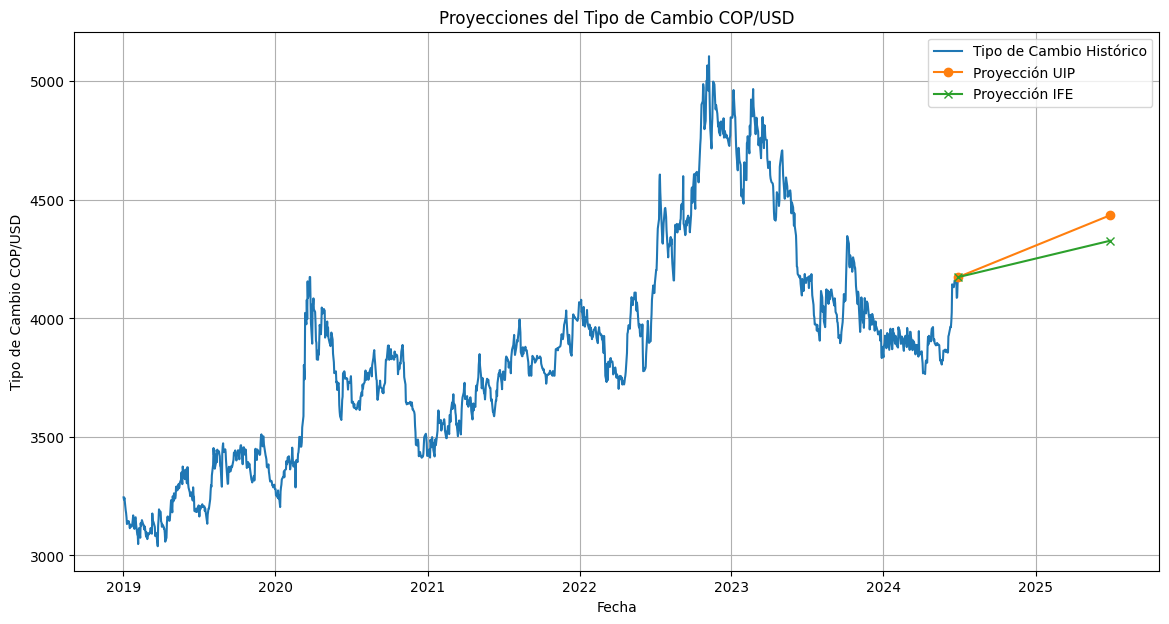

In [26]:
# Fechas de proyección
projection_dates = pd.date_range(start=data.index[-1], periods=2, freq='365D')

# Crear DataFrame para las proyecciones
projection_data = pd.DataFrame({
    'Fecha': projection_dates,
    'Tipo de Cambio UIP': [S, E_S_UIP],
    'Tipo de Cambio IFE': [S, E_S_IFE]
}).set_index('Fecha')

# Graficar las proyecciones
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Tipo de Cambio Histórico')
plt.plot(projection_data.index, projection_data['Tipo de Cambio UIP'], label='Proyección UIP', marker='o')
plt.plot(projection_data.index, projection_data['Tipo de Cambio IFE'], label='Proyección IFE', marker='x')
plt.title('Proyecciones del Tipo de Cambio COP/USD')
plt.xlabel('Fecha')
plt.ylabel('Tipo de Cambio COP/USD')
plt.legend()
plt.grid(True)
plt.show()


### Cálculo de Tasas Forward USDCOP

In [27]:
# Calcular las tasas forward
forward_rates = {}
for d in days:
    forward_rate = spot_rate * ((1 + interest_rate_cop * (d / 365)) / (1 + interest_rate_usd * (d / 360)))
    forward_rates[d] = forward_rate

# Mostrar las tasas forward calculadas
for d in days:
    print(f"Tasa Forward para {d} días: {forward_rates[d]:.2f} COP/USD")


Tasa Forward para 15 días: 4175.31 COP/USD
Tasa Forward para 20 días: 4178.82 COP/USD
Tasa Forward para 30 días: 4185.82 COP/USD


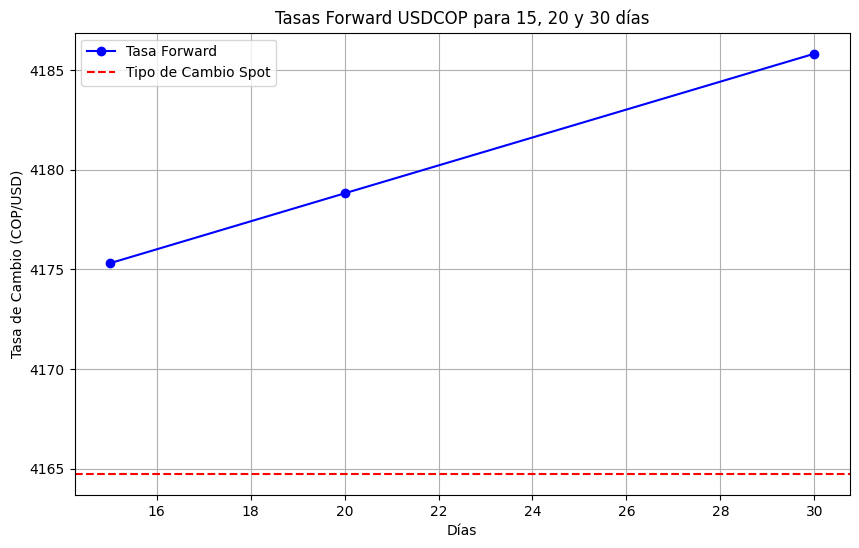

In [28]:
# Crear un DataFrame para las tasas forward
forward_data = pd.DataFrame(list(forward_rates.items()), columns=['Días', 'Tasa Forward'])
forward_data.set_index('Días', inplace=True)

# Graficar las tasas forward
plt.figure(figsize=(10, 6))
plt.plot(forward_data.index, forward_data['Tasa Forward'], marker='o', linestyle='-', color='b', label='Tasa Forward')
plt.axhline(y=spot_rate, color='r', linestyle='--', label='Tipo de Cambio Spot')
plt.title('Tasas Forward USDCOP para 15, 20 y 30 días')
plt.xlabel('Días')
plt.ylabel('Tasa de Cambio (COP/USD)')
plt.legend()
plt.grid(True)
plt.show()

## 3. Devaluacion Implicita

In [29]:
df = pd.read_excel('Tasa-Cambio/ndf-negociacion-devaluacion-residente.xlsx', skiprows=[0,1,2,3,4,5,7])
df =df.loc[:, ::2]
df = df.drop(columns=["Plazo (días).1"])
df = df.set_index("Plazo (días)")
col_names = ["0-14", "15-35","36-60","61-90","91-180",">180"]
compra = df.iloc[:,:6]
venta = df.iloc[:,6:]
compra.columns = col_names
venta.columns = col_names
# Eliminar outliers
compra = compra.drop(index=['2012-09-24', '2015-01-14', '2017-04-19', '2023-01-19'])
venta = venta.drop(index=['2016-12-19', '2017-02-07', '2017-02-08', '2017-03-31', '2021-08-10'])

In [30]:
fwds = pd.read_excel( 'Tasa-Cambio/tasa_cambio.xlsx', sheet_name= 'Dev_Implicita', usecols = [5,9,10,11], skiprows = [i for i in range(16)])
fwds = fwds.dropna()
# Definir los intervalos
bins = [0, 14, 35, 60, 90, 180, float('inf')]  # Usar float('inf') para el intervalo ">180"
labels = ['0-14', '15-35', '36-60', '61-90', '91-180', '>180']  # Etiquetas para cada intervalo
# Clasificar los valores en los intervalos
fwds['intervalo'] = pd.cut(fwds.Days, bins=bins, labels=labels, include_lowest=True)
fwds_dev = fwds
dev_media = pd.concat([compra,venta]).mean(axis=0)

In [31]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = compra.mean(axis=0).index,
        y = compra.mean(axis=0),
        name = 'Compra',
        line = dict(color='blue', dash = 'dash')
    )
)

fig.add_trace(
    go.Scatter(
        x = venta.mean(axis=0).index,
        y = venta.mean(axis=0),
        name = 'Venta',
        line = dict(color='orange', dash = 'dash')
    )
)

fig.add_trace(
    go.Scatter(
        x = dev_media.index,
        y = dev_media.values,
        name = 'Media',
        line = dict(color='black')
    )
)

ultima_disponible = np.mean([compra.iloc[-1,:],venta.iloc[-1,]],axis=0)
fig.add_trace(
    go.Scatter(
        x = dev_media.index,
        y = ultima_disponible,
        name = 'Ultima Disponible ({})'.format(compra.index[-1].strftime("%Y-%m-%d")),
        line = dict(color='gray')
    )
)

fwds_dev = fwds_dev.groupby('intervalo').mean().dropna()
fig.add_trace(
        go.Scatter(
            x = fwds_dev.index,
            y = fwds_dev['Dev Bid'],
            name = 'Compra (fwds)',
            line = dict(color='purple', dash = 'dash')
        )
    )

fig.add_trace(
        go.Scatter(
            x = fwds_dev.index,
            y = fwds_dev['Dev Ask'],
            name = 'Venta (fwds)',
            line = dict(color='pink', dash = 'dash')
        )
    )

fig.update_layout(
    title = 'Devaluación Implícita USDCOP',
    template = 'plotly_white',
    width = 1000, height = 500,
    legend=dict(
    orientation="h",
    entrywidth=180,
    yanchor="bottom",
    y=-0.3,
    xanchor="right",
    x=1
))
fig.update_xaxes(title_text="Plazo (Dias)")


<ipython-input-31-320c2d68679f>:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## 4. Valoración de Opciones

In [32]:
# Mostrar parámetros
print(f"Tipo de Cambio Spot (S): {spot_rate:.2f} COP/USD")
print(f"Tasa de Interés USD: {interest_rate_usd * 100:.2f}%")
print(f"Tasa de Interés COP: {interest_rate_cop * 100:.2f}%")
print(f"Volatilidad Anualizada: {volatility:.4f}")


Tipo de Cambio Spot (S): 4164.75 COP/USD
Tasa de Interés USD: 5.00%
Tasa de Interés COP: 11.25%
Volatilidad Anualizada: 0.1620


In [33]:
# Calcular las tasas forward
forward_rates = {}
for d in days:
    forward_rate = spot_rate * ((1 + interest_rate_cop * (d / 360)) / (1 + interest_rate_usd * (d / 360)))
    forward_rates[d] = forward_rate

# Mostrar las tasas forward calculadas
for d in days:
    print(f"Tasa Forward para {d} días: {forward_rates[d]:.2f} COP/USD")


Tasa Forward para 15 días: 4175.57 COP/USD
Tasa Forward para 20 días: 4179.17 COP/USD
Tasa Forward para 30 días: 4186.35 COP/USD


In [34]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

bs_call_prices = {}
bs_put_prices = {}
for d in days:
    T = d / 360
    F = forward_rates[d]
    bs_call_prices[d] = black_scholes_call(spot_rate, F, T, interest_rate_usd, volatility)
    bs_put_prices[d] = black_scholes_put(spot_rate, F, T, interest_rate_usd, volatility)

# Mostrar precios de opciones usando Black-Scholes
for d in days:
    print(f"Black-Scholes Call para {d} días: {bs_call_prices[d]:.2f} COP/USD")
    print(f"Black-Scholes Put para {d} días: {bs_put_prices[d]:.2f} COP/USD")


Black-Scholes Call para 15 días: 53.88 COP/USD
Black-Scholes Put para 15 días: 56.02 COP/USD
Black-Scholes Call para 20 días: 62.04 COP/USD
Black-Scholes Put para 20 días: 64.87 COP/USD
Black-Scholes Call para 30 días: 75.64 COP/USD
Black-Scholes Put para 30 días: 79.83 COP/USD


In [35]:
def binomial_option_pricing(S, K, T, r, sigma, steps, option_type='call'):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    # Inicializar precios terminales
    ST = np.zeros(steps + 1)
    ST[0] = S * d**steps
    for j in range(1, steps + 1):
        ST[j] = ST[j - 1] * u / d

    # Inicializar valores de la opción
    option_values = np.maximum(0, (ST - K) if option_type == 'call' else (K - ST))

    # Retroceder a través del árbol binomial
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            option_values[j] = (p * option_values[j + 1] + (1 - p) * option_values[j]) * disc

    return option_values[0]

binomial_call_prices = {}
binomial_put_prices = {}
steps = 100
for d in days:
    T = d / 360
    F = forward_rates[d]
    binomial_call_prices[d] = binomial_option_pricing(spot_rate, F, T, interest_rate_usd, volatility, steps, 'call')
    binomial_put_prices[d] = binomial_option_pricing(spot_rate, F, T, interest_rate_usd, volatility, steps, 'put')

# Mostrar precios de opciones usando el modelo Binomial
for d in days:
    print(f"Binomial Call para {d} días: {binomial_call_prices[d]:.2f} COP/USD")
    print(f"Binomial Put para {d} días: {binomial_put_prices[d]:.2f} COP/USD")


Binomial Call para 15 días: 54.01 COP/USD
Binomial Put para 15 días: 56.14 COP/USD
Binomial Call para 20 días: 62.20 COP/USD
Binomial Put para 20 días: 65.03 COP/USD
Binomial Call para 30 días: 75.83 COP/USD
Binomial Put para 30 días: 80.02 COP/USD


In [36]:
def monte_carlo_option_pricing(S, K, T, r, sigma, simulations, option_type='call'):
    dt = T
    discount_factor = np.exp(-r * T)
    payoff_sum = 0.0

    for i in range(simulations):
        Z = np.random.standard_normal()
        ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
        payoff = max(0, ST - K) if option_type == 'call' else max(0, K - ST)
        payoff_sum += payoff

    option_price = discount_factor * (payoff_sum / simulations)
    return option_price

mc_call_prices = {}
mc_put_prices = {}
simulations = 10000
for d in days:
    T = d / 360
    F = forward_rates[d]
    mc_call_prices[d] = monte_carlo_option_pricing(spot_rate, F, T, interest_rate_usd, volatility, simulations, 'call')
    mc_put_prices[d] = monte_carlo_option_pricing(spot_rate, F, T, interest_rate_usd, volatility, simulations, 'put')

# Mostrar precios de opciones usando el modelo Monte Carlo
for d in days:
    print(f"Monte Carlo Call para {d} días: {mc_call_prices[d]:.2f} COP/USD")
    print(f"Monte Carlo Put para {d} días: {mc_put_prices[d]:.2f} COP/USD")


Monte Carlo Call para 15 días: 53.94 COP/USD
Monte Carlo Put para 15 días: 55.19 COP/USD
Monte Carlo Call para 20 días: 64.54 COP/USD
Monte Carlo Put para 20 días: 64.62 COP/USD
Monte Carlo Call para 30 días: 76.76 COP/USD
Monte Carlo Put para 30 días: 80.70 COP/USD


In [37]:
def trinomial_price_tree(s0,T,n, sigma):
    dt = T/(365*n)
    u = np.exp(2*sigma*np.sqrt(dt/2))
    d = 1/u
    m = 1
    price = pd.DataFrame(np.zeros((n+1,2*n+1)))
    price.loc[0,0] = s0
    for i in range(n):
        for j in range(2*i+1):
            price.loc[i+1,j] = price.loc[i,j]*d
            price.loc[i+1,j+1] = price.loc[i,j]*m
            price.loc[i+1,j+2] = price.loc[i,j]*u
    return price

def trinomial_tree(price, K, call_put, T,n, sigma, r, type):
    ttree = pd.DataFrame(index = price.index, columns= price.columns)
    dt = T/(365*n)
    p = (np.exp(r*dt/2)-np.exp(-sigma*np.sqrt(dt/2)))/(np.exp(sigma*np.sqrt(dt/2))-np.exp(-sigma*np.sqrt(dt/2)))
    p_u = p**2
    p_d = (1-p)**2
    p_m = 2*p*(1-p)
    for i in range(n,-1,-1):
        for j in range(2*i+1):
            if i == n:
                payoff = compute_payoff(call_put, price.loc[i,j], K)
                ttree.loc[i,j]= max(payoff,0)
            else:
                value = (ttree.loc[i+1,j]*p_d+ ttree.loc[i+1,j+2]*p_u +ttree.loc[i+1,j+1]*p_m)*np.exp(-r*dt)
                if type == 'American':
                    payoff = compute_payoff(call_put, price.loc[i,j], K)
                    ttree.loc[i,j]= max(max(payoff,0), value)
                else:
                    ttree.loc[i,j]= value
    return ttree

def compute_payoff(call_put, s, K):
    if call_put == 'Call':
        payoff = s - K
    else:
        payoff = K- s
    return payoff

def trinomial_pricing(s0:float, K:float, T: float, n: int, sigma: float, r: float, call_put:str, type: str, plot: bool):
  if call_put not in ['Call', 'Put']:
      return "Option should be either Call or Put"
  if type not in ['European', 'American']:
      return "Option should be European or American"
  price = trinomial_price_tree(s0,T,n, sigma)
  tree = trinomial_tree(price, K, call_put, T,n, sigma, r, type)
  return tree.loc[0,0]


trin_call_prices = {}
trin_put_prices = {}
for d in days:
    T = d
    F = forward_rates[d]
    trin_call_prices[d] = trinomial_pricing(s0 = spot_rate, K = F, T = T, n = 50, sigma = volatility, r = interest_rate_usd , call_put = 'Call', type = 'European', plot = False)
    trin_put_prices[d] = trinomial_pricing(s0 = spot_rate, K = F, T = T, n = 50, sigma = volatility, r = interest_rate_usd , call_put = 'Put', type = 'European', plot = False)

In [38]:

# Crear un DataFrame para comparar precios de opciones
comparison_data = {
    'Días': days,
    'BS Call': [bs_call_prices[d] for d in days],
    'Binomial Call': [binomial_call_prices[d] for d in days],
    'Trinomial Call': [trin_call_prices[d] for d in days],
    'Monte Carlo Call': [mc_call_prices[d] for d in days],
    'BS Put': [bs_put_prices[d] for d in days],
    'Binomial Put': [binomial_put_prices[d] for d in days],
    'Trinomial Put': [trin_put_prices[d] for d in days],
    'Monte Carlo Put': [mc_put_prices[d] for d in days]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df

Días    BS Call  Binomial Call  Trinomial Call  Monte Carlo Call  \
0    15  53.883948      54.007376       53.571693         53.940370   
1    20  62.044030      62.197939       61.684366         64.540392   
2    30  75.638836      75.825294       75.174786         76.762472   

      BS Put  Binomial Put  Trinomial Put  Monte Carlo Put  
0  56.017047     56.140475      55.823712        55.191650  
1  64.872210     65.026119      64.671133        64.619796  
2  79.833395     80.019853      79.607306        80.695865

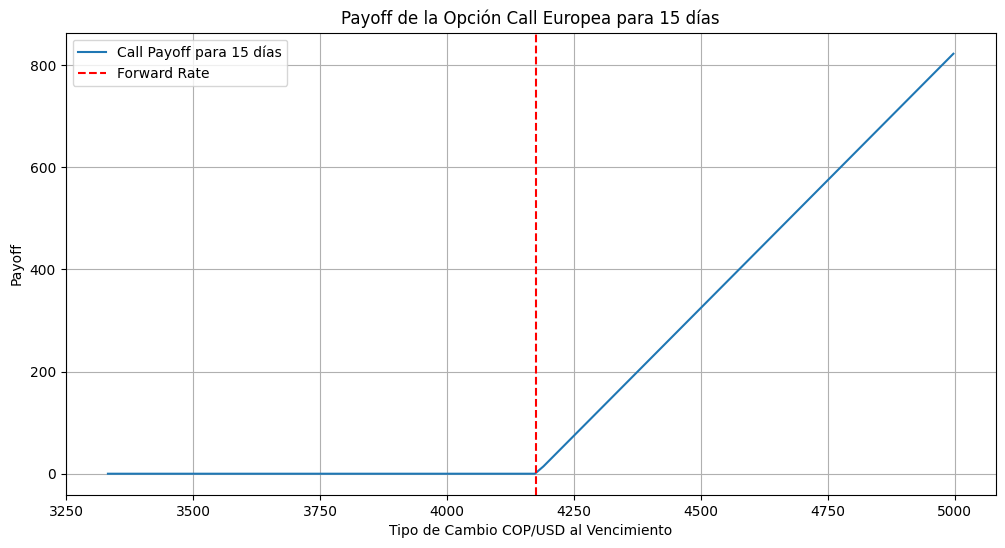

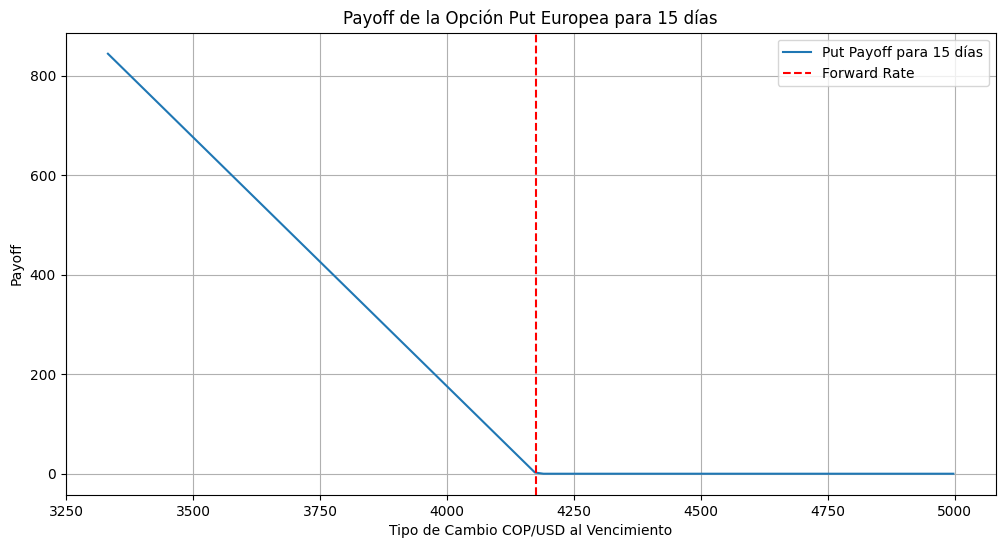

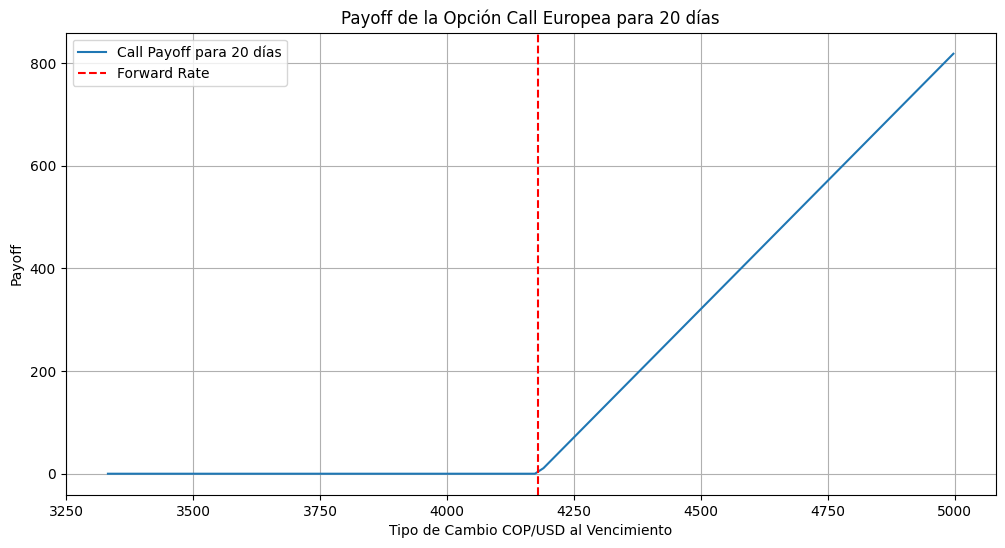

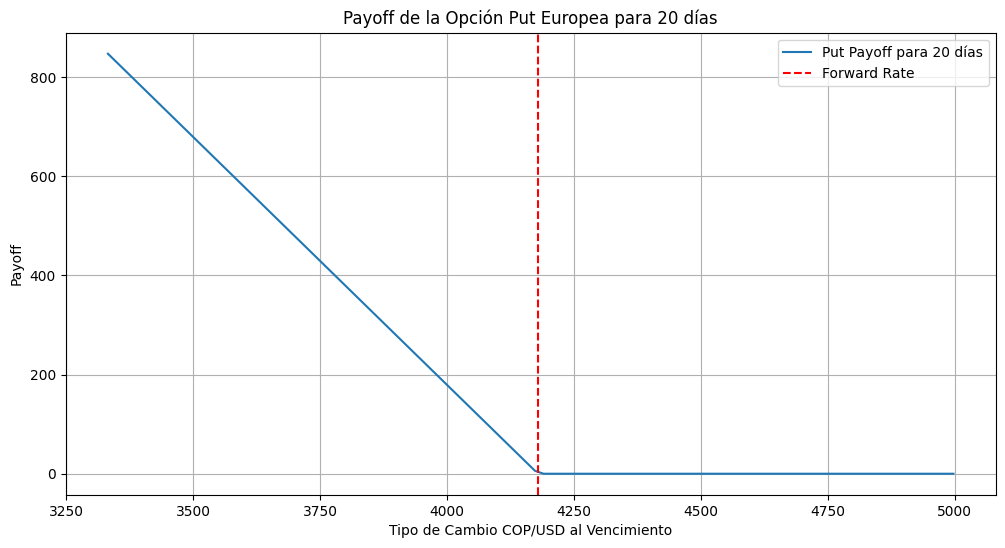

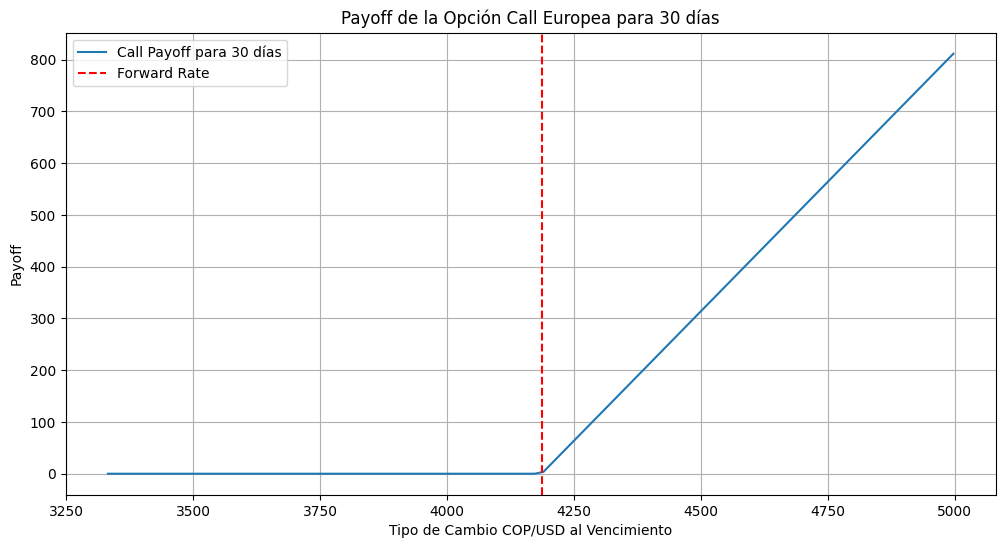

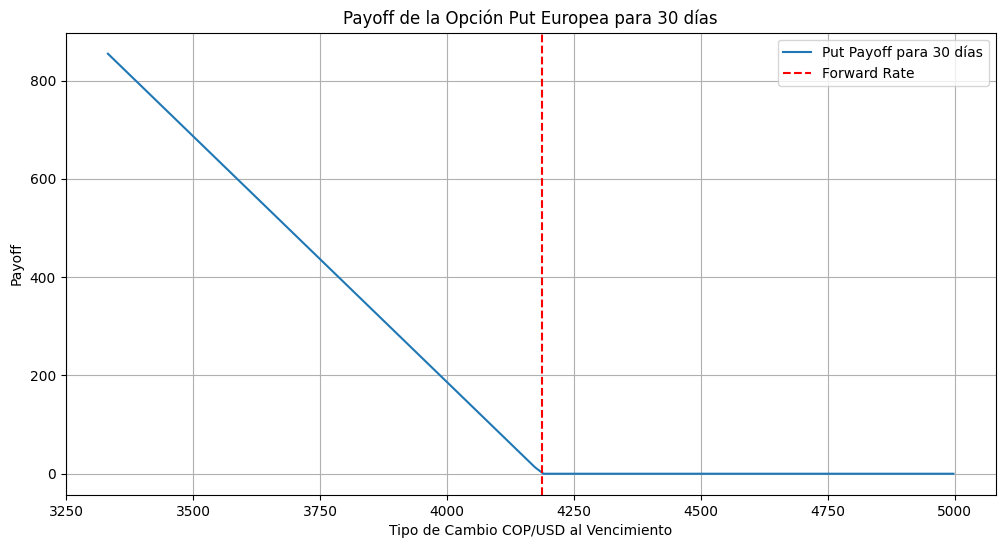

In [39]:
# Definir un rango de precios del subyacente al vencimiento
price_range = np.linspace(spot_rate * 0.8, spot_rate * 1.2, 100)

# Calcular los payoffs para diferentes días
for d in days:
    forward_rate = forward_rates[d]

    # Payoff de la opción call
    call_payoff = np.maximum(0, price_range - forward_rate)

    # Payoff de la opción put
    put_payoff = np.maximum(0, forward_rate - price_range)

    # Graficar el payoff de la opción call
    plt.figure(figsize=(12, 6))
    plt.plot(price_range, call_payoff, label=f'Call Payoff para {d} días')
    plt.axvline(x=forward_rate, color='r', linestyle='--', label='Forward Rate')
    plt.title(f'Payoff de la Opción Call Europea para {d} días')
    plt.xlabel('Tipo de Cambio COP/USD al Vencimiento')
    plt.ylabel('Payoff')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graficar el payoff de la opción put
    plt.figure(figsize=(12, 6))
    plt.plot(price_range, put_payoff, label=f'Put Payoff para {d} días')
    plt.axvline(x=forward_rate, color='r', linestyle='--', label='Forward Rate')
    plt.title(f'Payoff de la Opción Put Europea para {d} días')
    plt.xlabel('Tipo de Cambio COP/USD al Vencimiento')
    plt.ylabel('Payoff')
    plt.legend()
    plt.grid(True)
    plt.show()


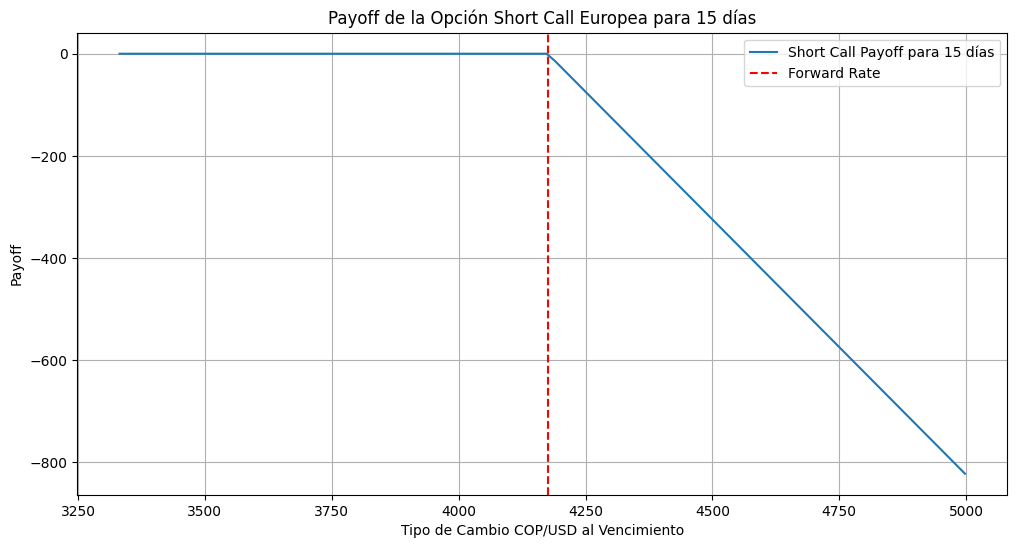

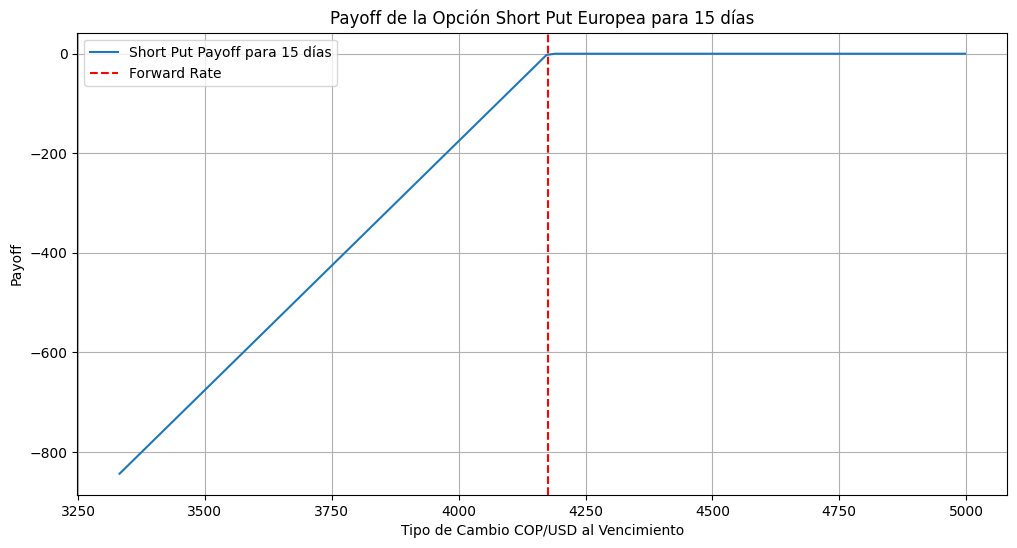

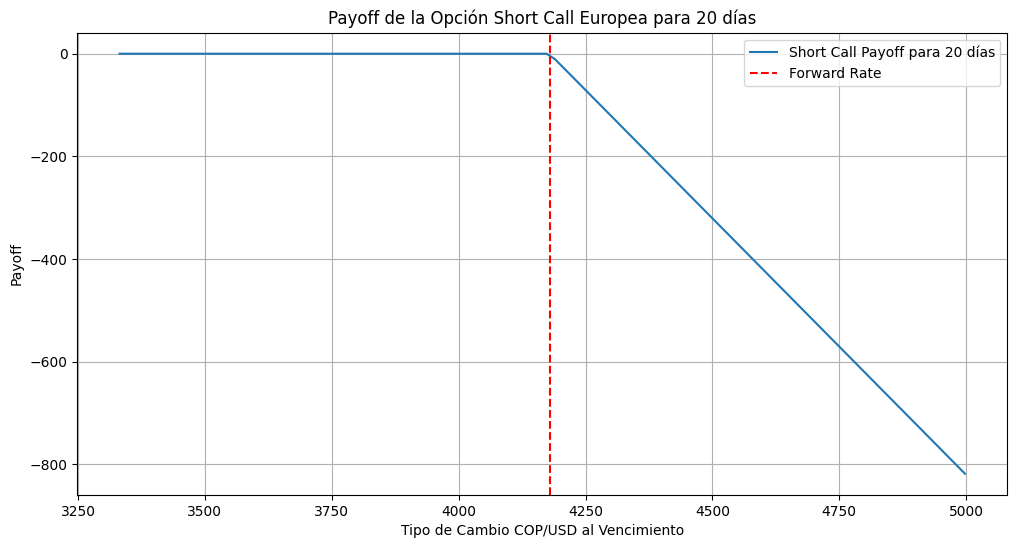

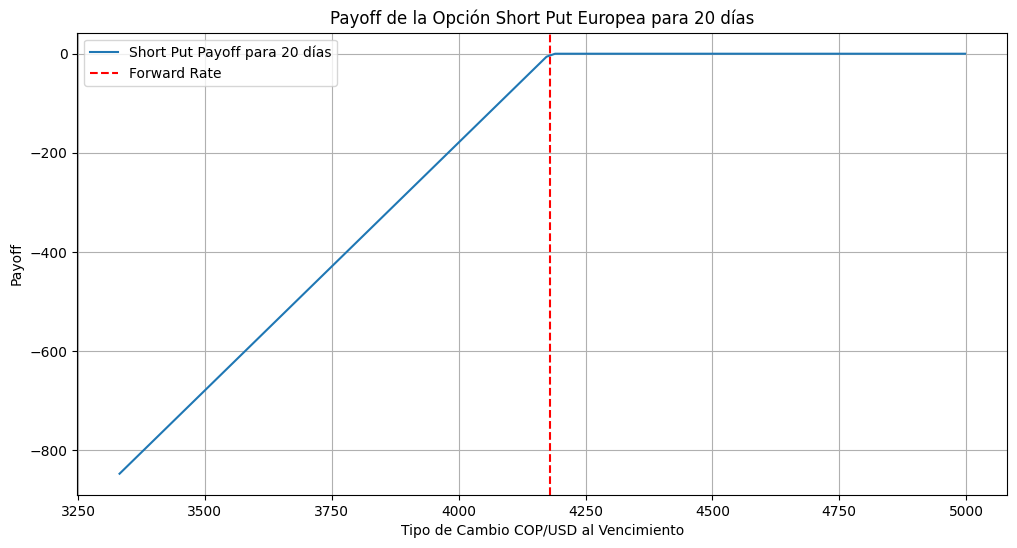

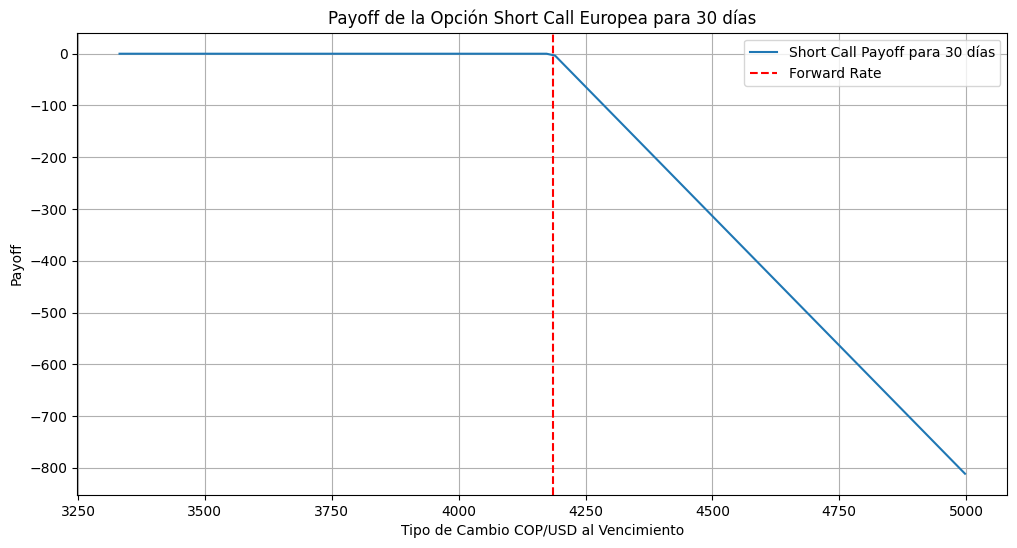

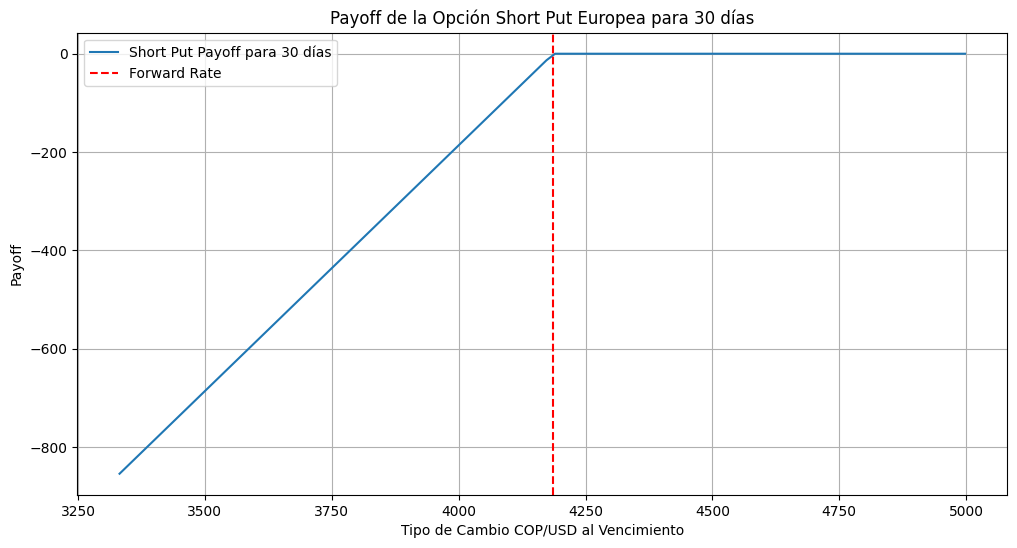

In [40]:
# Definir un rango de precios del subyacente al vencimiento
price_range = np.linspace(spot_rate * 0.8, spot_rate * 1.2, 100)

# Calcular los payoffs para diferentes días
for d in days:
    forward_rate = forward_rates[d]

    # Payoff de la opción short call
    short_call_payoff = -np.maximum(0, price_range - forward_rate)

    # Payoff de la opción short put
    short_put_payoff = -np.maximum(0, forward_rate - price_range)

    # Graficar el payoff de la opción short call
    plt.figure(figsize=(12, 6))
    plt.plot(price_range, short_call_payoff, label=f'Short Call Payoff para {d} días')
    plt.axvline(x=forward_rate, color='r', linestyle='--', label='Forward Rate')
    plt.title(f'Payoff de la Opción Short Call Europea para {d} días')
    plt.xlabel('Tipo de Cambio COP/USD al Vencimiento')
    plt.ylabel('Payoff')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graficar el payoff de la opción short put
    plt.figure(figsize=(12, 6))
    plt.plot(price_range, short_put_payoff, label=f'Short Put Payoff para {d} días')
    plt.axvline(x=forward_rate, color='r', linestyle='--', label='Forward Rate')
    plt.title(f'Payoff de la Opción Short Put Europea para {d} días')
    plt.xlabel('Tipo de Cambio COP/USD al Vencimiento')
    plt.ylabel('Payoff')
    plt.legend()
    plt.grid(True)
    plt.show()


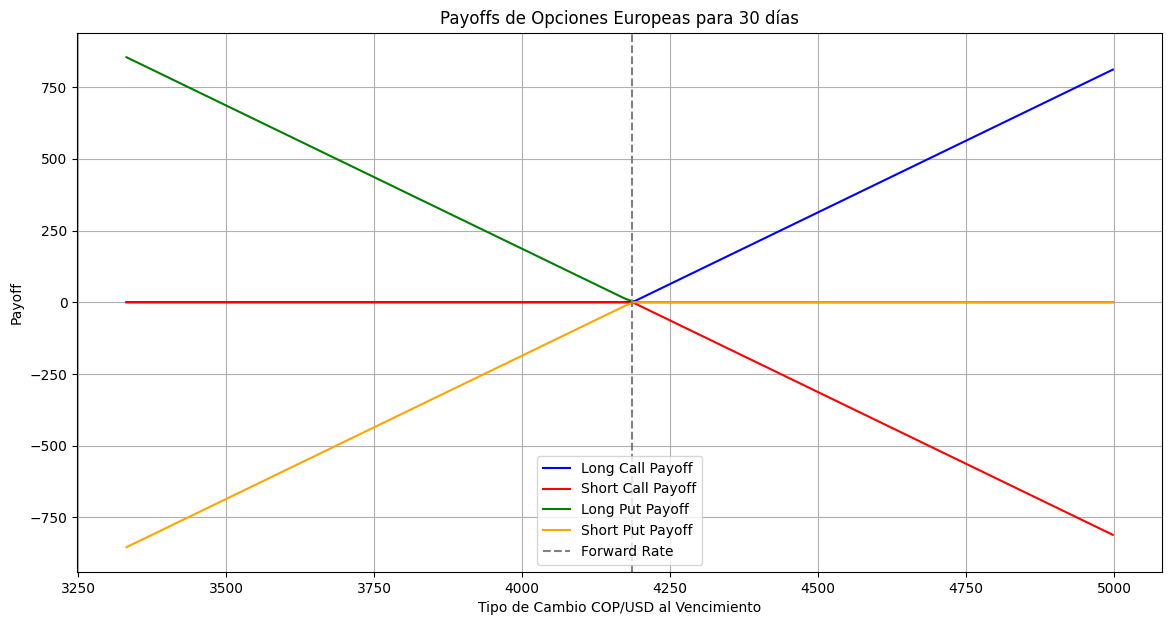

In [41]:
# Definir el rango de precios del subyacente al vencimiento
price_range = np.linspace(spot_rate * 0.8, spot_rate * 1.2, 100)

# Elegir un día para ilustrar (por ejemplo, 30 días)
d = 30
forward_rate = forward_rates[d]

# Calcular los payoffs
long_call_payoff = np.maximum(0, price_range - forward_rate)
short_call_payoff = -np.maximum(0, price_range - forward_rate)
long_put_payoff = np.maximum(0, forward_rate - price_range)
short_put_payoff = -np.maximum(0, forward_rate - price_range)

# Graficar los payoffs
plt.figure(figsize=(14, 7))

# Long Call
plt.plot(price_range, long_call_payoff, label='Long Call Payoff', color='blue')

# Short Call
plt.plot(price_range, short_call_payoff, label='Short Call Payoff', color='red')

# Long Put
plt.plot(price_range, long_put_payoff, label='Long Put Payoff', color='green')

# Short Put
plt.plot(price_range, short_put_payoff, label='Short Put Payoff', color='orange')

# Forward Rate Line
plt.axvline(x=forward_rate, color='gray', linestyle='--', label='Forward Rate')

# Configuración del gráfico
plt.title(f'Payoffs de Opciones Europeas para {d} días')
plt.xlabel('Tipo de Cambio COP/USD al Vencimiento')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()


## 5. Griegas

In [42]:
class Greeks:
  def delta(St, K, r, sigma,t, T, type, pos):
      if type not in ['call', 'put']:
          raise ValueError("Parameter 'type' should be either 'call' or 'put'")
      d_1 = d1(St, K, r, sigma, t, T)
      Nd1 = norm.cdf(d_1)
      if type == 'call':
          return pos*Nd1
      else:
          return pos*(Nd1 - 1)

  def theta(St, K, r, sigma, t, T, type, pos):
      if type not in ['call', 'put']:
          raise ValueError("Parameter 'type' should be either 'call' or 'put'")
      d1_value = d1(St, K, r, sigma, t, T)
      d2_value = d2(St, K, r, sigma, t, T)
      time_to_expiry = T - t
      if type == 'call':
          theta_value = (-St * norm.pdf(d1_value) * sigma / (2 * np.sqrt(time_to_expiry)) -
                      r * K * np.exp(-r * time_to_expiry) * norm.cdf(d2_value))
      else:
          theta_value = (-St * norm.pdf(d1_value) * sigma / (2 * np.sqrt(time_to_expiry)) +
                      r * K * np.exp(-r * time_to_expiry) * norm.cdf(-d2_value))
      return pos * theta_value

  def gamma(St, K, r, sigma, t, T, pos):
      d1_value = d1(St, K, r, sigma, t, T)
      return pos * norm.pdf(d1_value) / (St * sigma * np.sqrt(T - t))

  def vega(St, K, r, sigma, t, T, pos):
      d1_value = d1(St, K, r, sigma, t, T)
      return pos * St * norm.pdf(d1_value) * np.sqrt(T - t) * 0.01

  def rho(St, K, r, sigma, t, T, type, pos):
      if type not in ['call', 'put']:
          raise ValueError("Parameter 'type' should be either 'call' or 'put'")
      d2_value = d2(St, K, r, sigma, t, T)
      if type == 'call':
          result = K * (T - t) * np.exp(-r * (T - t)) * norm.cdf(d2_value)
      else:
          result = -K * (T - t) * np.exp(-r * (T - t)) * norm.cdf(-d2_value)
      return pos * result * 0.01

  def volga(St, K, r, sigma, t, T, pos):
      d1_value = d1(St, K, r, sigma, t, T)
      d2_value = d2(St, K, r, sigma, t, T)
      return pos * St * norm.pdf(d1_value) * np.sqrt(T - t) * d1_value * d2_value / sigma

  def vanna(St, K, r, sigma, t, T, pos):
      d1_value = d1(St, K, r, sigma, t, T)
      d2_value = d2(St, K, r, sigma, t, T)
      return pos * (norm.pdf(d1_value) * d2_value / sigma)

  def delta_hedging(S, K, r, sigma,t, T, type, pos, n_opt):
      df = pd.DataFrame()
      df['Spot price'] = S
      df['Delta'] = df.apply(lambda s: Greeks.delta(s['Spot price'], K, r, sigma, s.name, T, type, pos), axis = 1)
      strategy = {'call': {-1 : 'long (buy)' , 1: 'short (sell)'},
                  'put': {-1:'short (sell)' , 1: 'long(buy)'}}
      action = strategy[type][pos]
      df['Strategy'] = df['Delta'].apply(lambda d: '{} {} shares'.format(action, np.round(d*n_opt,2)))
      return df

def d1(St, K, r, sigma, t, T):
    return (np.log(St/K) + (r + 0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))

def d2(St, K, r, sigma, t, T):
    return d1(St, K, r, sigma, t, T) - sigma * np.sqrt(T - t)


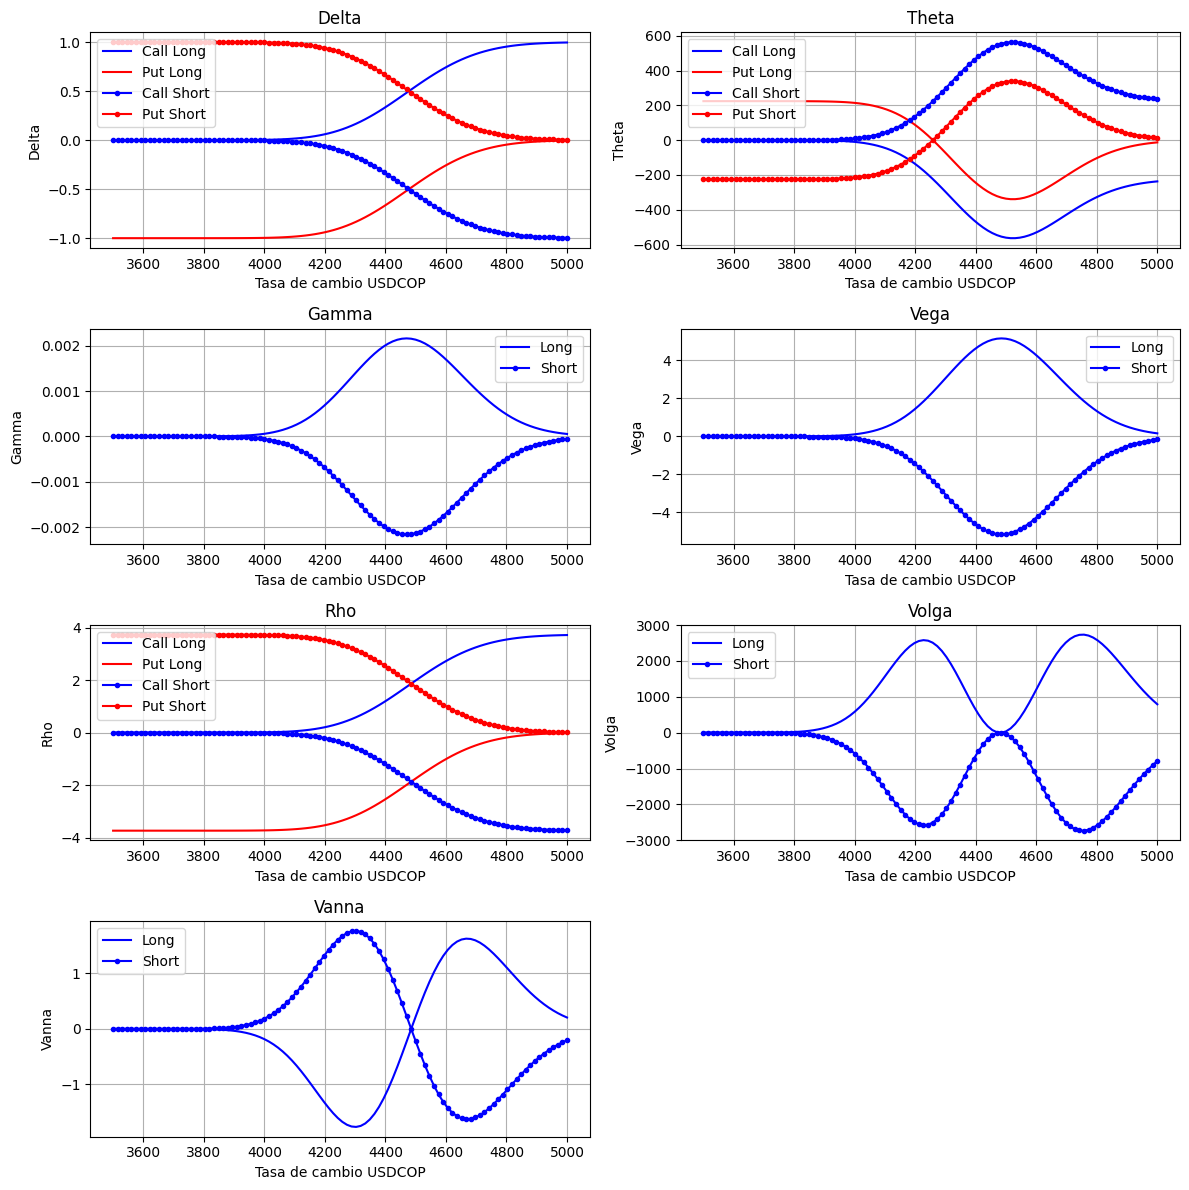

In [43]:
def plot_griegas(S, K, r, sigma, t, T):
  # Calculo de Griegas Posicion Larga
  delta_call_values = [Greeks.delta(St, K, r, sigma,t, T, 'call', 1) for St in S]
  delta_put_values= [Greeks.delta(St, K, r, sigma,t, T, 'put', 1) for St in S]
  theta_call_values = [Greeks.theta(St, K, r, sigma,t, T, 'call', 1) for St in S]
  theta_put_values = [Greeks.theta(St, K, r, sigma,t, T, 'put', 1) for St in S]
  gamma_values = [Greeks.gamma(St, K, r, sigma, t, T, 1) for St in S]
  vega_values = [Greeks.vega(St, K, r, sigma, t, T, 1) for St in S]
  rho_call_values = [Greeks.rho(St, K, r, sigma, t, T, 'call', 1) for St in S]
  rho_put_values = [Greeks.rho(St, K, r, sigma, t, T, 'put', 1) for St in S]
  volga_values = [Greeks.volga(St, K, r, sigma, t, T, 1) for St in S]
  vanna_values = [Greeks.vanna(St, K, r, sigma, t, T, 1) for St in S ]
  # Calculo de Griegas Posicion Corta
  delta_call_values_short = [Greeks.delta(St, K, r, sigma,t, T, 'call', -1) for St in S]
  delta_put_values_short  = [Greeks.delta(St, K, r, sigma,t, T, 'put', -1) for St in S]
  theta_call_values_short  = [Greeks.theta(St, K, r, sigma,t, T, 'call', -1) for St in S]
  theta_put_values_short  = [Greeks.theta(St, K, r, sigma,t, T, 'put', -1) for St in S]
  gamma_values_short  = [Greeks.gamma(St, K, r, sigma, t, T, -1) for St in S]
  vega_values_short  = [Greeks.vega(St, K, r, sigma, t, T, -1) for St in S]
  rho_call_values_short  = [Greeks.rho(St, K, r, sigma, t, T, 'call', -1) for St in S]
  rho_put_values_short  = [Greeks.rho(St, K, r, sigma, t, T, 'put', -1) for St in S]
  volga_values_short  = [Greeks.volga(St, K, r, sigma, t, T, -1) for St in S]
  vanna_values_short  = [Greeks.vanna(St, K, r, sigma, t, T,- 1) for St in S ]
  # Crear la gráfica
  plt.figure(figsize=(12, 12))
  #Delta
  plt.subplot(4, 2, 1)
  plt.plot(S, delta_call_values, label='Call Long', color='blue')
  plt.plot(S, delta_put_values, label='Put Long', color='red')
  plt.plot(S, delta_call_values_short, label='Call Short', color='blue', marker= '.')
  plt.plot(S, delta_put_values_short, label='Put Short', color='red',  marker= '.')
  plt.title('Delta')
  plt.xlabel('Tasa de cambio USDCOP')
  plt.ylabel('Delta')
  plt.grid(True)
  plt.legend()
  # Theta
  plt.subplot(4, 2, 2)
  plt.plot(S, theta_call_values, label='Call Long', color='blue')
  plt.plot(S, theta_put_values, label='Put Long', color='red')
  plt.plot(S, theta_call_values_short, label='Call Short', color='blue', marker= '.')
  plt.plot(S, theta_put_values_short, label='Put Short', color='red',  marker= '.')
  plt.title('Theta')
  plt.xlabel('Tasa de cambio USDCOP')
  plt.ylabel('Theta')
  plt.grid(True)
  plt.legend()
  # Gamma
  plt.subplot(4, 2, 3)
  plt.plot(S, gamma_values, label='Long', color='blue')
  plt.plot(S, gamma_values_short, label='Short', color='blue', marker= '.')
  plt.title('Gamma')
  plt.xlabel('Tasa de cambio USDCOP')
  plt.ylabel('Gamma')
  plt.grid(True)
  plt.legend()
  # Vega
  plt.subplot(4, 2, 4)
  plt.plot(S, vega_values, label='Long', color='blue')
  plt.plot(S, vega_values_short, label='Short', color='blue', marker= '.')
  plt.title('Vega')
  plt.xlabel('Tasa de cambio USDCOP')
  plt.ylabel('Vega')
  plt.grid(True)
  plt.legend()
  # Rho
  plt.subplot(4, 2, 5)
  plt.plot(S, rho_call_values, label='Call Long', color='blue')
  plt.plot(S, rho_put_values, label='Put Long', color='red')
  plt.plot(S, rho_call_values_short, label='Call Short', color='blue', marker= '.')
  plt.plot(S, rho_put_values_short, label='Put Short', color='red',  marker= '.')
  plt.title('Rho')
  plt.xlabel('Tasa de cambio USDCOP')
  plt.ylabel('Rho')
  plt.grid(True)
  plt.legend()
  # Volga
  plt.subplot(4, 2, 6)
  plt.plot(S, volga_values, label='Long', color='blue')
  plt.plot(S, volga_values_short, label='Short', color='blue', marker= '.')
  plt.title('Volga')
  plt.xlabel('Tasa de cambio USDCOP')
  plt.ylabel('Volga')
  plt.grid(True)
  plt.legend()
  # Vanna
  plt.subplot(4, 2, 7)
  plt.plot(S, vanna_values, label='Long', color='blue')
  plt.plot(S, vanna_values_short, label='Short', color='blue', marker= '.')
  plt.title('Vanna')
  plt.xlabel('Tasa de cambio USDCOP')
  plt.ylabel('Vanna')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
# Rango de precios de la acción
S = np.linspace(3500, 5000, 100)
K = 4500
r = 0.05 # tasa interes usd
sigma = prices['Ret_log'].std()*np.sqrt(252)
T = 30/360
t = 0
plot_griegas(S, K, r, sigma, t, T)

In [44]:
# Calcular las tasas forward
forward_rates = {}
for d in days:
    forward_rate = spot_rate * ((1 + interest_rate_cop * (d / 360)) / (1 + interest_rate_usd * (d / 360)))
    forward_rates[d] = forward_rate

# Funciones para calcular las griegas usando el modelo de Black-Scholes

def d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

def d2(S, K, T, r, sigma):
    return d1(S, K, T, r, sigma) - sigma * np.sqrt(T)

def delta_call(S, K, T, r, sigma):
    return norm.cdf(d1(S, K, T, r, sigma))

def delta_put(S, K, T, r, sigma):
    return norm.cdf(d1(S, K, T, r, sigma)) - 1

def gamma(S, K, T, r, sigma):
    return norm.pdf(d1(S, K, T, r, sigma)) / (S * sigma * np.sqrt(T))

def theta_call(S, K, T, r, sigma):
    d1_val = d1(S, K, T, r, sigma)
    d2_val = d2(S, K, T, r, sigma)
    term1 = - (S * norm.pdf(d1_val) * sigma) / (2 * np.sqrt(T))
    term2 = r * K * np.exp(-r * T) * norm.cdf(d2_val)
    return term1 - term2

def theta_put(S, K, T, r, sigma):
    d1_val = d1(S, K, T, r, sigma)
    d2_val = d2(S, K, T, r, sigma)
    term1 = - (S * norm.pdf(d1_val) * sigma) / (2 * np.sqrt(T))
    term2 = r * K * np.exp(-r * T) * norm.cdf(-d2_val)
    return term1 + term2

def vega(S, K, T, r, sigma):
    return S * norm.pdf(d1(S, K, T, r, sigma)) * np.sqrt(T)

def rho_call(S, K, T, r, sigma):
    return K * T * np.exp(-r * T) * norm.cdf(d2(S, K, T, r, sigma))

def rho_put(S, K, T, r, sigma):
    return -K * T * np.exp(-r * T) * norm.cdf(-d2(S, K, T, r, sigma))

# Calcular y mostrar las griegas para cada plazo
for d in days:
    T = d / 360
    F = forward_rates[d]

    delta_c = delta_call(spot_rate, F, T, interest_rate_usd, volatility)
    delta_p = delta_put(spot_rate, F, T, interest_rate_usd, volatility)
    gamma_val = gamma(spot_rate, F, T, interest_rate_usd, volatility)
    theta_c = theta_call(spot_rate, F, T, interest_rate_usd, volatility)
    theta_p = theta_put(spot_rate, F, T, interest_rate_usd, volatility)
    vega_val = vega(spot_rate, F, T, interest_rate_usd, volatility)
    rho_c = rho_call(spot_rate, F, T, interest_rate_usd, volatility)
    rho_p = rho_put(spot_rate, F, T, interest_rate_usd, volatility)

    print(f"Griegas para {d} días:")
    print(f"Delta Call: {delta_c:.4f}, Delta Put: {delta_p:.4f}")
    print(f"Gamma: {gamma_val:.4f}")
    print(f"Theta Call: {theta_c:.4f}, Theta Put: {theta_p:.4f}")
    print(f"Vega: {vega_val:.4f}")
    print(f"Rho Call: {rho_c:.4f}, Rho Put: {rho_p:.4f}")
    print("\n")


Griegas para 15 días:
Delta Call: 0.5004, Delta Put: -0.4996
Gamma: 0.0029
Theta Call: -760.6990, Theta Put: -552.3549
Vega: 339.1510
Rho Call: 84.5927, Rho Put: -89.0274


Griegas para 20 días:
Delta Call: 0.5005, Delta Put: -0.4995
Gamma: 0.0025
Theta Call: -671.9983, Theta Put: -463.6194
Vega: 391.6178
Rho Call: 112.3612, Rho Put: -119.1709


Griegas para 30 días:
Delta Call: 0.5007, Delta Put: -0.4993
Gamma: 0.0020
Theta Call: -566.6060, Theta Put: -358.1588
Vega: 479.6314
Rho Call: 167.4840, Rho Put: -179.9280




## 6. Estrategias de Cobertura


In [45]:
# Parámetros de la opción
K = 3900  # Precio de ejercicio
T = 30 / 360  # Tiempo hasta el vencimiento en años
sigma = volatility  # Volatilidad
num_options = 100  # Ejemplo: poseer 100 opciones call

### Delta hedging Estático Posiciones Larga y Corta en Opciones Call tipo Europeo

In [46]:
# Calcular Delta
delta = delta_call(spot_rate, K, T, interest_rate_usd, sigma)
print(f"Delta de la opción call: {delta:.4f}")

# Número de opciones
num_options = 100  # Ejemplo: poseer 100 opciones call

# Calcular la posición en el subyacente necesaria para cubrir la posición en las opciones
num_shares_to_hedge = delta * num_options
print(f"Número de unidades del subyacente necesarias para la cobertura: {num_shares_to_hedge:.2f}")

# Implementar la estrategia de Delta Hedging
# Comprar la cantidad calculada de unidades del subyacente
position_value = num_shares_to_hedge * spot_rate
print(f"Valor de la posición en el subyacente para cobertura: {position_value:.2f} COP")


Delta de la opción call: 0.9354
Número de unidades del subyacente necesarias para la cobertura: 93.54
Valor de la posición en el subyacente para cobertura: 389567.51 COP


### Estrategia Dinámica para Delta-hedging

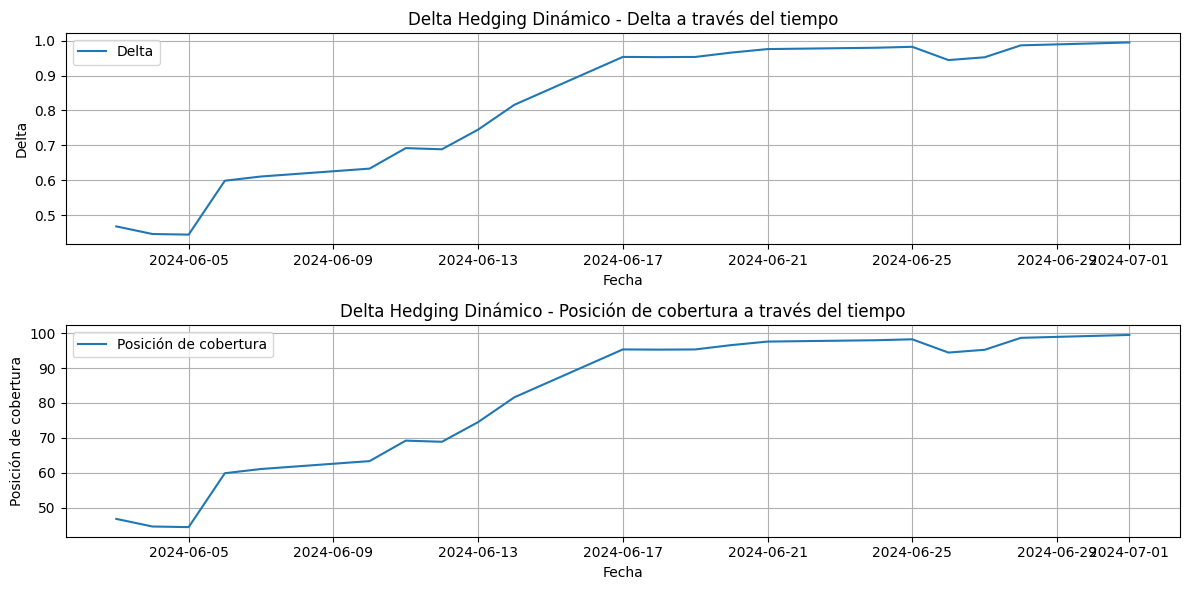

In [47]:
# Crear una serie temporal para simular el precio del subyacente y la cobertura
simulation_dates = pd.date_range(start='2024-06-01', end='2024-07-01', freq='B')
simulated_prices = data['Close'][-len(simulation_dates):].values
deltas = []
hedge_positions = []
portfolio_values = []

for i, S in enumerate(simulated_prices):
    T_remaining = (30 - i) / 360  # Tiempo restante hasta el vencimiento en años
    if T_remaining <= 0:
        break
    delta = delta_call(S, K, T_remaining, interest_rate_usd, sigma)
    hedge_position = delta * num_options
    deltas.append(delta)
    hedge_positions.append(hedge_position)
    portfolio_value = num_options * delta * S - hedge_position * S
    portfolio_values.append(portfolio_value)

# Graficar los resultados

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(simulation_dates[:len(deltas)], deltas, label='Delta')
plt.title('Delta Hedging Dinámico - Delta a través del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Delta')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(simulation_dates[:len(hedge_positions)], hedge_positions, label='Posición de cobertura')
plt.title('Delta Hedging Dinámico - Posición de cobertura a través del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Posición de cobertura')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Estrategia Gamma - Neutral

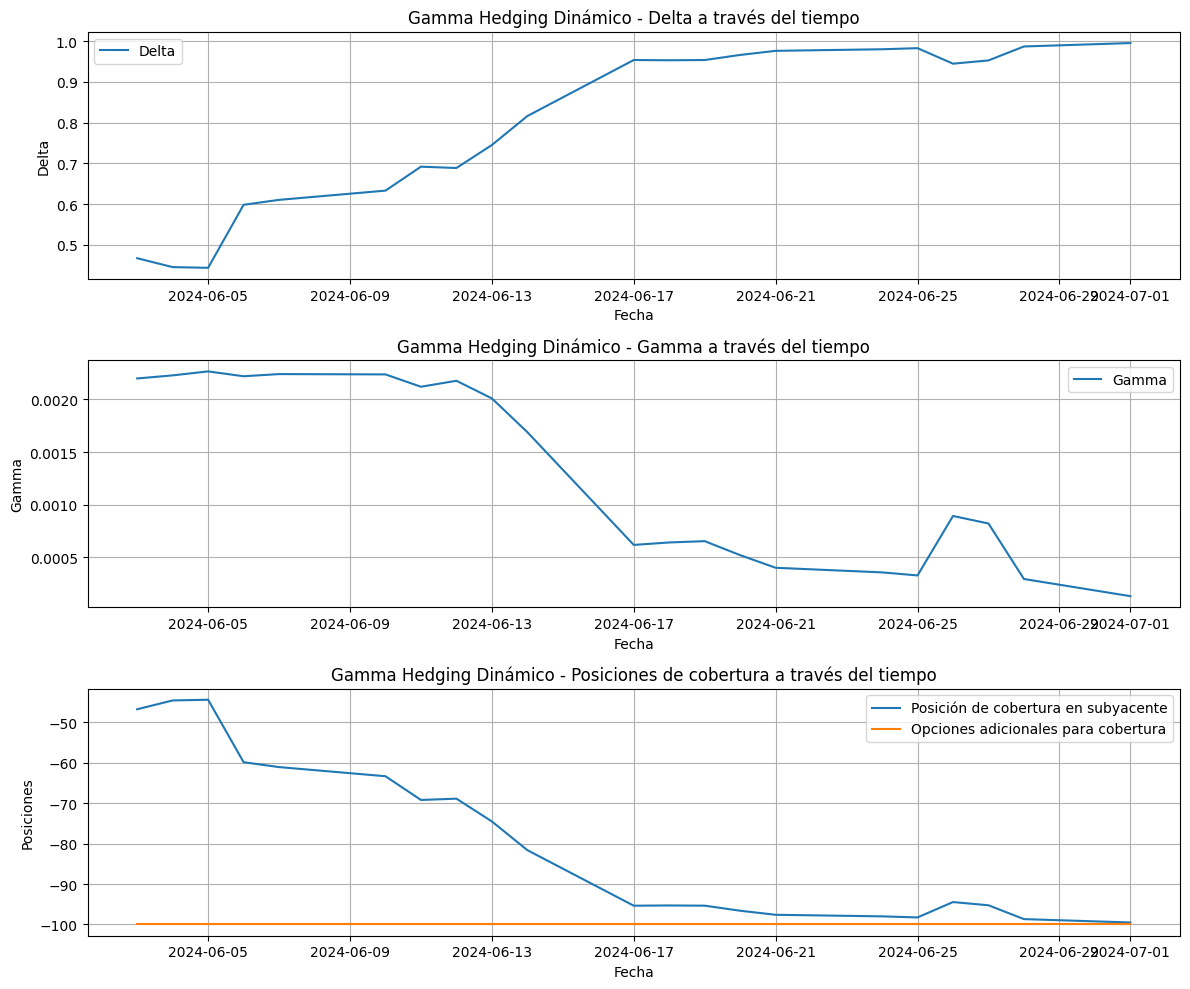

In [48]:
# Crear una serie temporal para simular el precio del subyacente y la cobertura
simulation_dates = pd.date_range(start='2024-06-01', end='2024-07-01', freq='B')
simulated_prices = data['Close'][-len(simulation_dates):].values
deltas = []
gammas = []
hedge_positions = []
additional_options = []
portfolio_values = []

for i, S in enumerate(simulated_prices):
    T_remaining = (30 - i) / 360  # Tiempo restante hasta el vencimiento en años
    if T_remaining <= 0:
        break
    delta = delta_call(S, K, T_remaining, interest_rate_usd, sigma)
    gamma_val = gamma(S, K, T_remaining, interest_rate_usd, sigma)
    hedge_position = -delta * num_options  # Para una posición larga en calls, se vende el subyacente

    # Necesitamos calcular la cantidad de opciones adicionales para cubrir la gamma
    # Asumimos que las opciones adicionales tienen el mismo strike y vencimiento
    gamma_per_option = gamma_val * num_options
    additional_option_count = -gamma_per_option / gamma_val

    deltas.append(delta)
    gammas.append(gamma_val)
    hedge_positions.append(hedge_position)
    additional_options.append(additional_option_count)
    portfolio_value = num_options * delta * S + hedge_position * S + additional_option_count * S * gamma_val
    portfolio_values.append(portfolio_value)

# Graficar los resultados

plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(simulation_dates[:len(deltas)], deltas, label='Delta')
plt.title('Gamma Hedging Dinámico - Delta a través del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Delta')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(simulation_dates[:len(gammas)], gammas, label='Gamma')
plt.title('Gamma Hedging Dinámico - Gamma a través del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Gamma')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(simulation_dates[:len(hedge_positions)], hedge_positions, label='Posición de cobertura en subyacente')
plt.plot(simulation_dates[:len(additional_options)], additional_options, label='Opciones adicionales para cobertura')
plt.title('Gamma Hedging Dinámico - Posiciones de cobertura a través del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Posiciones')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 7. Estrategias con Opciones


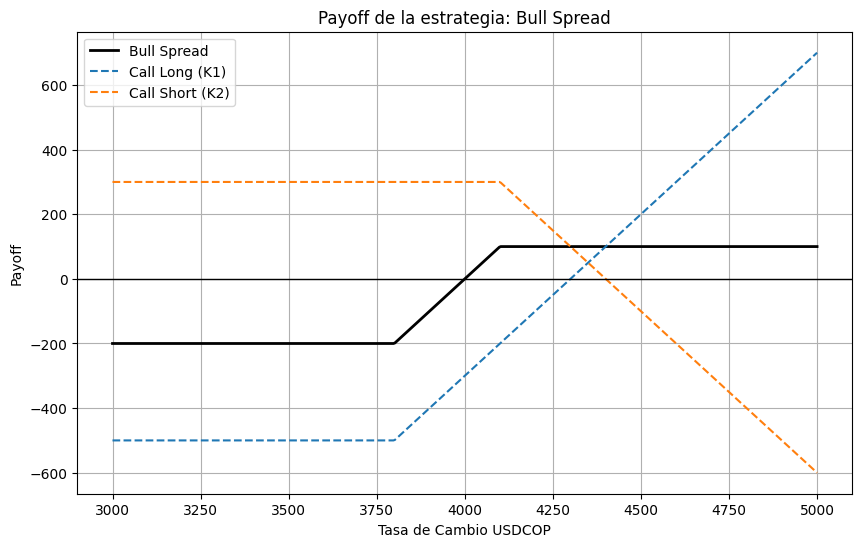

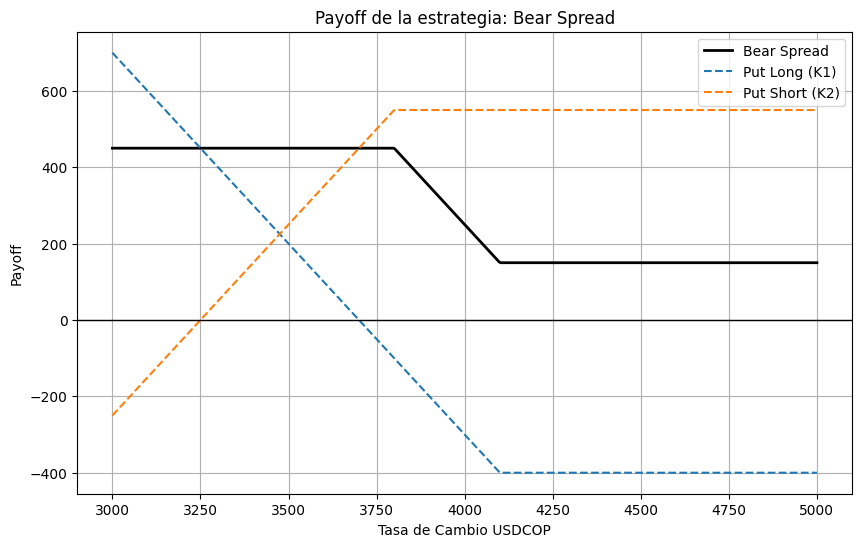

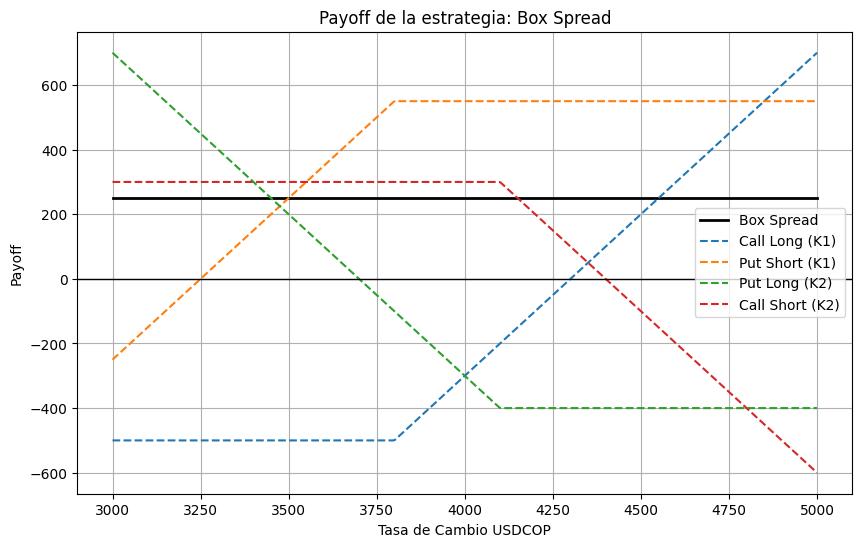

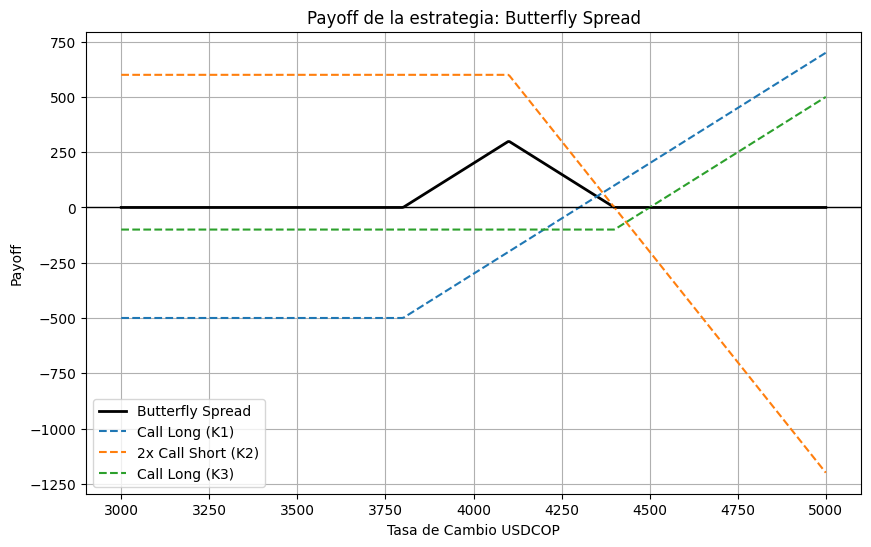

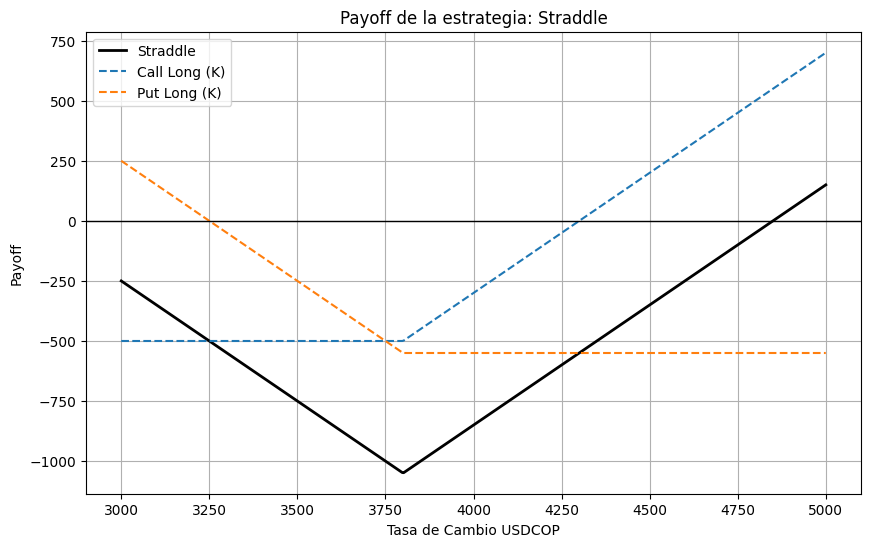

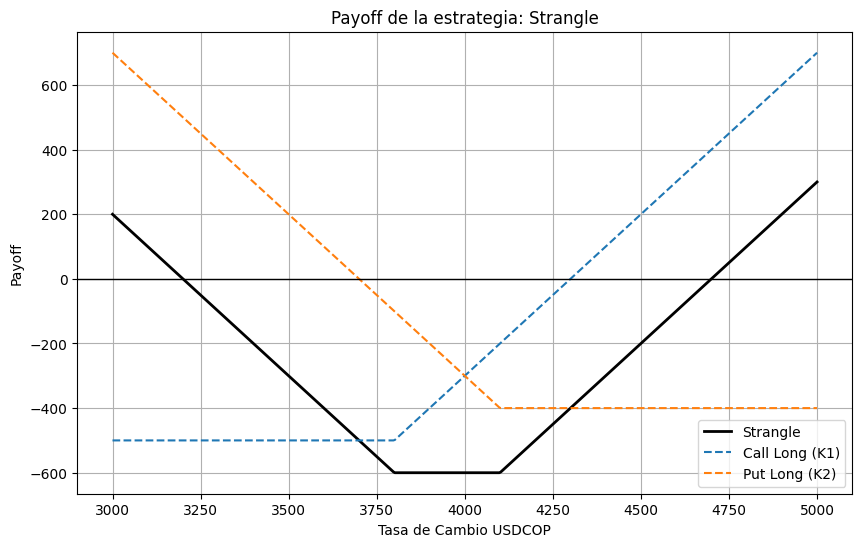

In [49]:
# Función para las opciones call
def call_payoff(S, K, option_price):
    return np.maximum(S - K, 0) - option_price

# Función para las opciones put
def put_payoff(S, K, option_price):
    return np.maximum(K - S, 0) - option_price

# 1. Bull Spread (utiliza calls)
def bull_spread(S, K1, K2, price1, price2):
    call_long = call_payoff(S, K1, price1)
    call_short = -call_payoff(S, K2, price2)
    payoff = call_long + call_short
    return payoff, call_long, call_short

# 2. Bear Spread (utiliza puts)
def bear_spread(S, K1, K2, price1, price2):
    put_long = put_payoff(S, K1, price1)
    put_short = -put_payoff(S, K2, price2)
    payoff = put_long + put_short
    return payoff, put_long, put_short

# 3. Box Spread (long call and short put at K1, long put and short call at K2)
def box_spread(S, K1, K2, price_call1, price_put1, price_put2, price_call2):
    call_long = call_payoff(S, K1, price_call1)
    put_short = -put_payoff(S, K1, price_put1)
    put_long = put_payoff(S, K2, price_put2)
    call_short = -call_payoff(S, K2, price_call2)
    payoff = call_long + put_long + call_short + put_short
    return payoff, call_long, put_short, put_long, call_short

# 4. Butterfly Spread (utiliza calls)
def butterfly_spread(S, K1, K2, K3, price1, price2, price3):
    call_long1 = call_payoff(S, K1, price1)
    call_short = -2 * call_payoff(S, K2, price2)
    call_long2 = call_payoff(S, K3, price3)
    payoff = call_long1 + call_short + call_long2
    return payoff, call_long1, call_short, call_long2

# 5. Straddle (long call and long put at the same strike)
def straddle(S, K, price_call, price_put):
    call_long = call_payoff(S, K, price_call)
    put_long = put_payoff(S, K, price_put)
    payoff = call_long + put_long
    return payoff, call_long, put_long

# 6. Strangle (long call and long put at different strikes)
def strangle(S, K1, K2, price_call, price_put):
    call_long = call_payoff(S, K1, price_call)
    put_long = put_payoff(S, K2, price_put)
    payoff = call_long + put_long
    return payoff, call_long, put_long

# Función para graficar las estrategias con payoffs individuales
def plot_strategy(S, payoffs, individual_payoffs, strategy_name, labels):
    plt.figure(figsize=(10, 6))

    # Graficar el payoff total
    plt.plot(S, payoffs, label=strategy_name, color='black', lw=2)

    # Graficar los payoffs individuales con líneas punteadas
    for i, ind_payoff in enumerate(individual_payoffs):
        plt.plot(S, ind_payoff, '--', label=labels[i])

    plt.axhline(0, color='black', lw=1)
    plt.title(f"Payoff de la estrategia: {strategy_name}")
    plt.xlabel('Tasa de Cambio USDCOP')
    plt.ylabel('Payoff')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejemplo de uso
S = np.linspace(3000, 5000, 500)  # Rango de precios de la acción

# Parámetros para las estrategias
K1 = 3800  # Strike price 1
K2 = 4100  # Strike price 2
K3 = 4400  # Strike price para Butterfly

# Precios de las opciones
price_call1 = 500  # Precio de la opción call con K1
price_call2 = 300  # Precio de la opción call con K2
price_call3 = 100  # Precio de la opción call con K2
price_put1 = 550   # Precio de la opción put con K1
price_put2 = 400   # Precio de la opción put con K2

# Bull Spread
bull_payoff, bull_call_long, bull_call_short = bull_spread(S, K1, K2, price_call1, price_call2)
plot_strategy(S, bull_payoff, [bull_call_long, bull_call_short], 'Bull Spread', ['Call Long (K1)', 'Call Short (K2)'])

# Bear Spread
bear_payoff, bear_put_long, bear_put_short = bear_spread(S, K2, K1, price_put2, price_put1)
plot_strategy(S, bear_payoff, [bear_put_long, bear_put_short], 'Bear Spread', ['Put Long (K1)', 'Put Short (K2)'])

# Box Spread
box_payoff, box_call_long, box_put_short, box_put_long, box_call_short = box_spread(S, K1, K2, price_call1, price_put1, price_put2, price_call2)
plot_strategy(S, box_payoff, [box_call_long, box_put_short, box_put_long, box_call_short], 'Box Spread', ['Call Long (K1)', 'Put Short (K1)', 'Put Long (K2)', 'Call Short (K2)'])

# Butterfly Spread
butterfly_payoff, butterfly_call_long1, butterfly_call_short, butterfly_call_long2 = butterfly_spread(S, K1, K2, K3, price_call1, price_call2, price_call3)
plot_strategy(S, butterfly_payoff, [butterfly_call_long1, butterfly_call_short, butterfly_call_long2], 'Butterfly Spread', ['Call Long (K1)', '2x Call Short (K2)', 'Call Long (K3)'])

# Straddle
straddle_payoff, straddle_call_long, straddle_put_long = straddle(S, K1, price_call1, price_put1)
plot_strategy(S, straddle_payoff, [straddle_call_long, straddle_put_long], 'Straddle', ['Call Long (K)', 'Put Long (K)'])

# Strangle
strangle_payoff, strangle_call_long, strangle_put_long = strangle(S, K1, K2, price_call1, price_put2)
plot_strategy(S, strangle_payoff, [strangle_call_long, strangle_put_long], 'Strangle', ['Call Long (K1)', 'Put Long (K2)'])
